# Principal Component Analysis on Pal Coordinates
###### Garett Brown

In [1]:
import rebound
import numpy as np
from ctypes import c_double, pointer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA
from sklearn.decomposition import PCA
from scipy import signal
import scipy.optimize

In [2]:
sim = rebound.Simulation.from_file("ss.bin")
N = sim.N
G = sim.G
# sim.move_to_com()
# sim.save("ss.bin")
masses = np.zeros(sim.N)
for i in range(sim.N):
    masses[i] = sim.particles[i].m

### Conversion methods for pal and cartesian coordinates.

In [3]:
def sim_to_car(sim):
    cart = np.zeros((sim.N,6))
    for i in range(0,sim.N):
        cart[i] = [sim.particles[i].x,sim.particles[i].y,sim.particles[i].z,
                   sim.particles[i].vx,sim.particles[i].vy,sim.particles[i].vz]
    return cart.reshape(-1)

In [4]:
def get_pal_single(primary, particle):
    a, lamda, h, k, ix, iy = c_double(0), c_double(0), c_double(0), c_double(0), c_double(0), c_double(0)
    rebound.clibrebound.reb_tools_particle_to_pal(c_double(G), particle, primary, 
                                                  pointer(a), pointer(lamda), pointer(k), 
                                                  pointer(h), pointer(ix), pointer(iy))
    return np.array([a.value, lamda.value, h.value, k.value, ix.value, iy.value])

def sim_to_pal(sim):
    pal = np.zeros((sim.N-1,6))
    com = sim.particles[0]
    for i in range(1,sim.N):
        pal[i-1] = get_pal_single(com, sim.particles[i])
        com = (com.m*com + sim.particles[i].m*sim.particles[i])/(com.m+sim.particles[i].m)
    return pal.reshape(-1)

In [5]:
def pal_to_sim(pal):
    pal = pal.reshape((N-1,6))
    sim = rebound.Simulation()
    sim.G = G
    sim.add(m=masses[0])
    com = sim.particles[0]
    for i in range(1,N):
        sim.add(primary=com,m=masses[i],a=pal[i-1,0],l=pal[i-1,1],h=pal[i-1,2],
                k=pal[i-1,3],ix=pal[i-1,4],iy=pal[i-1,5])
        com = (com.m*com + sim.particles[i].m*sim.particles[i])/(com.m+sim.particles[i].m)


    sim.move_to_com()
    return sim

### Metric comparing two simulations and returning an error.

In [6]:
def metric(sim1,sim2):
    cart1 = sim_to_car(sim1).reshape(-1,3)
    cart2 = sim_to_car(sim2).reshape(-1,3)
    m = 0.
    for i in range(cart1.shape[0]):
        length = (np.linalg.norm(cart1[i]) + np.linalg.norm(cart2[i]))/2.
        m += np.linalg.norm((cart1[i]-cart2[i])/length)
    return m       

### Run a simulation and collect samples.

In [7]:
tmax = 100.*2.*np.pi
Nsamples = 10000
tsamples = tmax*np.linspace(0,1, Nsamples, endpoint=False)
sim = rebound.Simulation.from_file("ss.bin")
palsamples = np.zeros((Nsamples,6*(N-1)))
cartsamples = np.zeros((Nsamples,6*(N)))
for i in range(Nsamples):
    sim.integrate(tsamples[i])
    palsamples[i] = sim_to_pal(sim)
    cartsamples[i] = sim_to_car(sim)

### Plot all parameters.

In [8]:
def plot_pal(t,pal,pal2=None):
    zeros = np.zeros(Nsamples)
    fig, axs = plt.subplots(N-1,6, figsize=(15,7),sharex=True)
    for i in range(N-1):
        for j in range(6):
            ax = axs[i,j]# = plt.subplot(N-1,6,1+i*6+j)
            ax.set_yticks([])
            ax.set_xticks([])
            mi, ma = np.min(pal[:,i*6+j]),np.max(pal[:,i*6+j])
            ax.set_ylim([mi-(ma-mi)*0.1,ma+(ma-mi)*0.1])
            ax.set_xlim([np.amin(t),np.amax(t)])
            if pal2 is not None:
                ax.scatter(t,pal2[:,i*6+j],s=5,color="lightblue")
            ax.scatter(t,pal[:,i*6+j],s=5,color="blue")
            prob = dict(facecolor='white', alpha=0.75, edgecolor='white')
            ax.text(0.05,0.7,"%.1e"%(ma-mi),transform = ax.transAxes,color="black",bbox=prob)
            mi, ma = np.min(pal[Nsamples//4:3*Nsamples//4,i*6+j]),np.max(pal[Nsamples//4:3*Nsamples//4,i*6+j])
            ax.text(0.05,0.2,"%.1e"%(ma-mi),transform = ax.transAxes,color="black",bbox=prob)
            ax.plot(t,zeros,color="black")
    fig.subplots_adjust(hspace=0.,wspace=0.)

In [9]:
# plot_pal(tsamples,palsamples)

### Remove linear increase in lambda and a polynomial from each coordinate.

In [10]:
def mod2pi(v):
    # fast, will not work for negative numbers
    return np.fmod(v+4.*np.pi,np.pi*2.)

In [11]:
palsampleslam = palsamples.copy()
sim = rebound.Simulation.from_file("ss.bin")
ns = np.zeros(N-1)
lam0 = np.zeros(N-1)
for j in range(1,N):
    ns[j-1] = sim.particles[j].n
    lam0[j-1] = palsamples[0,6*(j-1)+1]-ns[j-1]*tsamples[i]
for i in range(Nsamples):
    for j in range(1,N):
        palsampleslam[i,6*(j-1)+1] = mod2pi((palsamples[i,6*(j-1)+1]-lam0[j-1])-mod2pi(ns[j-1]*tsamples[i])+3.*np.pi)

In [12]:
# plot_pal(tsamples,palsampleslam)

In [13]:
palsampleslampol = palsampleslam.copy()
for i in range((N-1)*6):
    pol = np.polyfit(tsamples,palsampleslam[:,i],4)
    palsampleslampol[:,i] -= np.polyval(pol,tsamples)

In [14]:
# plot_pal(tsamples,palsampleslampol)

### Principal Component Analysis

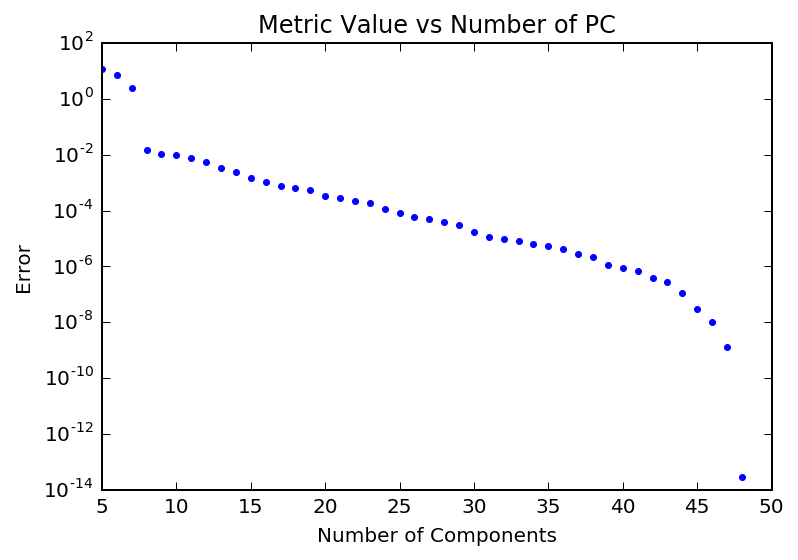

In [15]:
meanmet = np.load('mean_metric_PCA.npy')
tests = np.arange(5,49)
plt.plot(tests, meanmet, 'b.')
plt.title('Metric Value vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Error')
plt.show()

In [16]:
tests = np.arange(1,49)
ntests = len(tests)
def mean_pca_error_pal(palpca, plot=False):
    pca = PCA()
    palpcatrans = pca.fit_transform(palpca)
    mu = np.mean(palpca, axis=0)
    meanmet = np.zeros(ntests)
    for j,nComp in enumerate(tests):
        Xhat = np.dot(palpcatrans[:,:nComp], pca.components_[:nComp,:])
        Xhat += mu
        diff = np.absolute(palpca - Xhat)
        meanmet[j] = np.mean(np.mean(diff, axis=1))
    return meanmet

def plot_mean_pca_error(tests, pca_errors):
    plt.plot(tests, meanmet, 'b.')
    plt.title('Mean Difference vs Number of PC')
    plt.yscale('log')
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Error')
    plt.show()

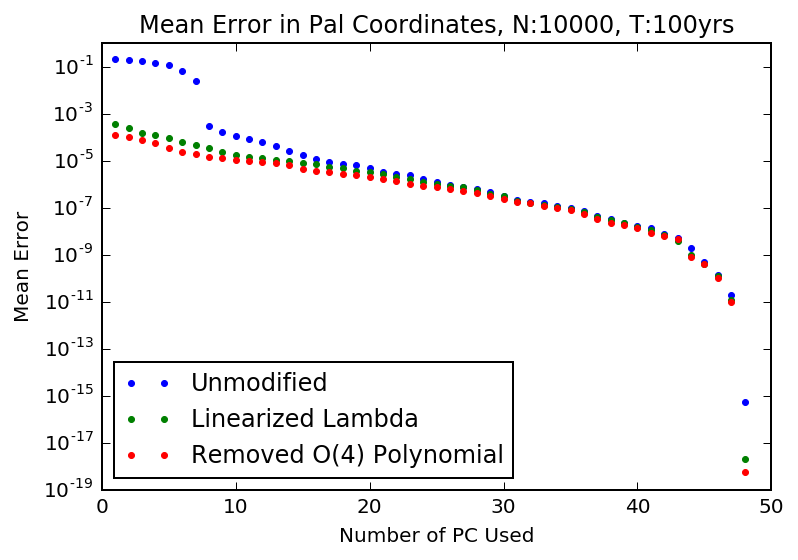

In [17]:
unmod = mean_pca_error_pal(palsamples)
mod = mean_pca_error_pal(palsampleslam)
modpol = mean_pca_error_pal(palsampleslampol)
attrib = 'N:'+str(Nsamples)+', T:'+str(int(np.round(tmax/(2*np.pi))))+'yrs'
plt.plot(tests, unmod, 'b.', tests, mod, 'g.', tests, modpol, 'r.')
plt.yscale('log')
plt.title('Mean Error in Pal Coordinates, '+ attrib)
plt.ylabel('Mean Error')
plt.xlabel('Number of PC Used')
plt.legend(('Unmodified', 'Linearized Lambda', 'Removed O(4) Polynomial'), loc=3)
# plt.savefig('Plots/'+attrib+'.pdf')
plt.show()

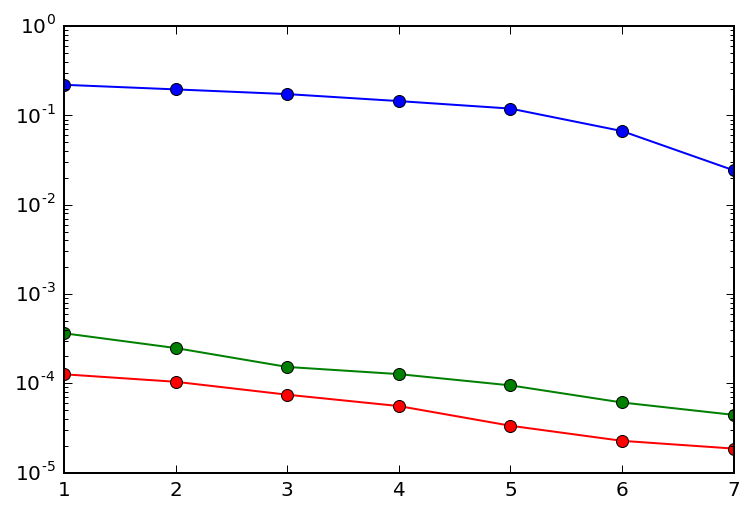

In [18]:
plt.plot(tests[:7], unmod[:7], 'b-o', tests[:7], mod[:7], 'g-o', tests[:7], modpol[:7], 'r-o')
plt.yscale('log')
plt.show()

Explained variance by first 7: 0.9961008614945501


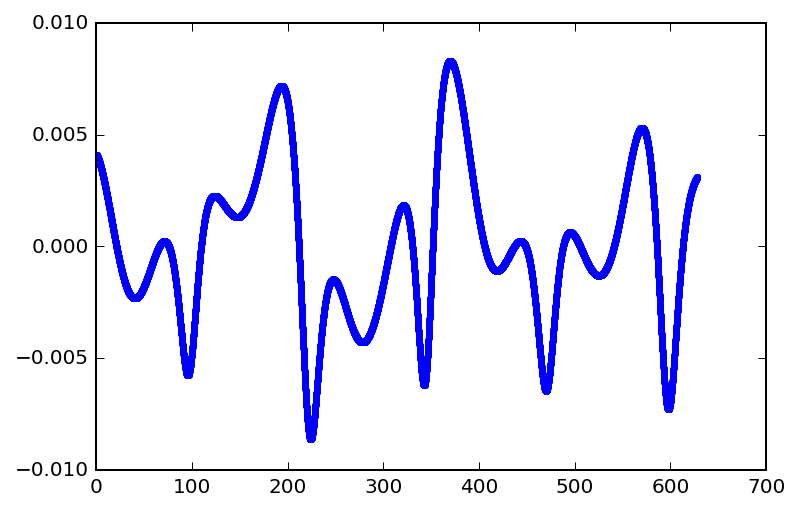

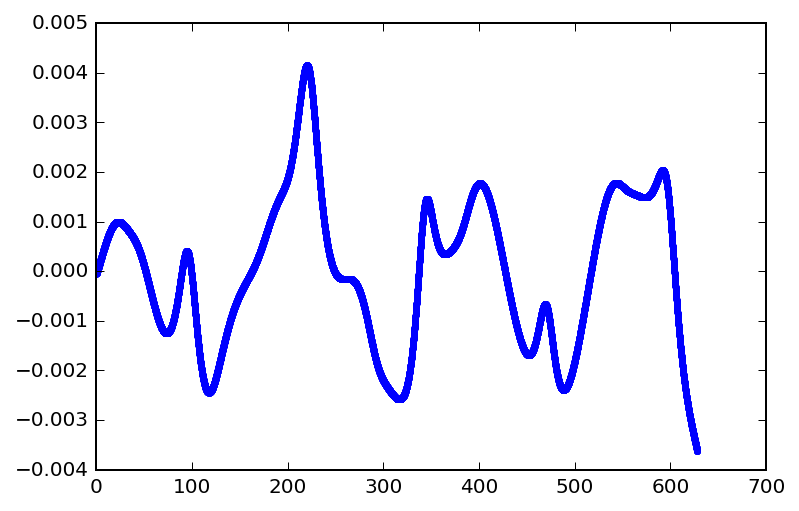

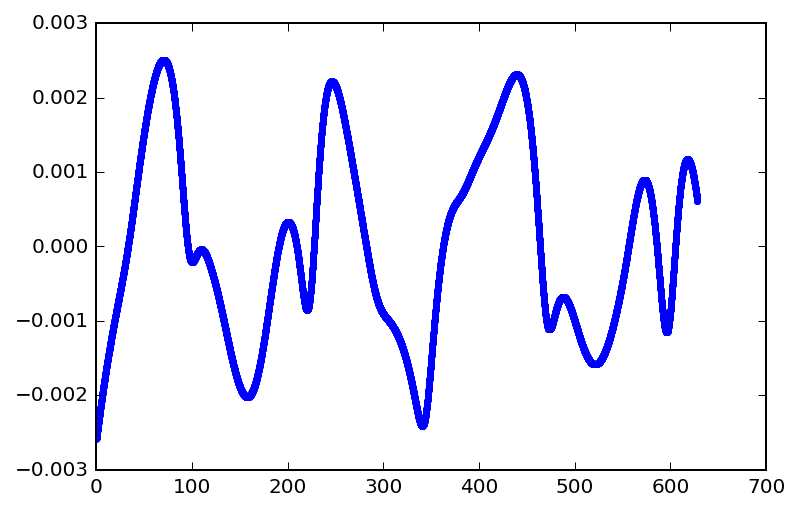

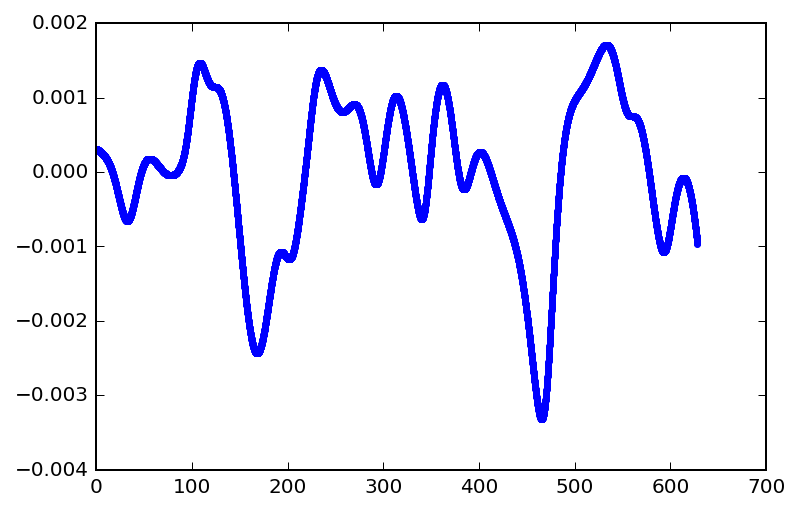

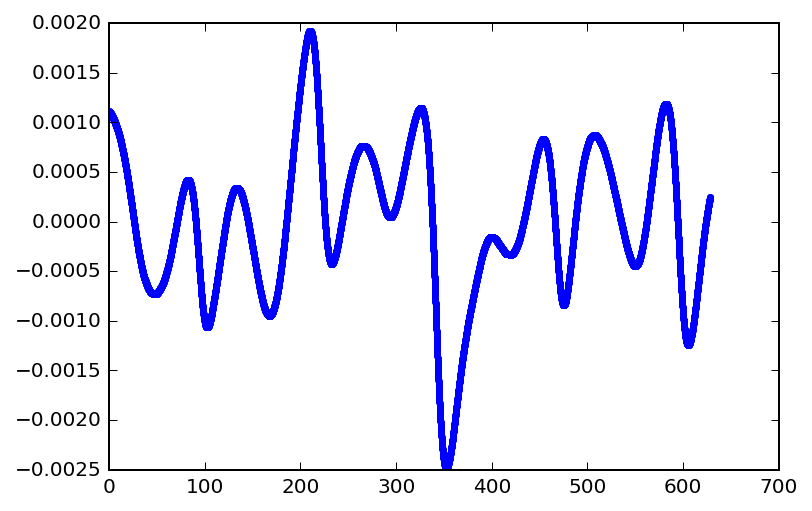

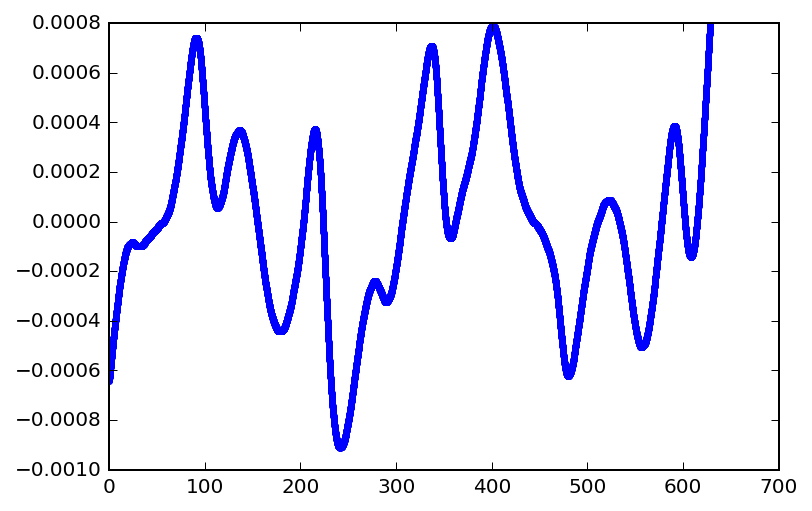

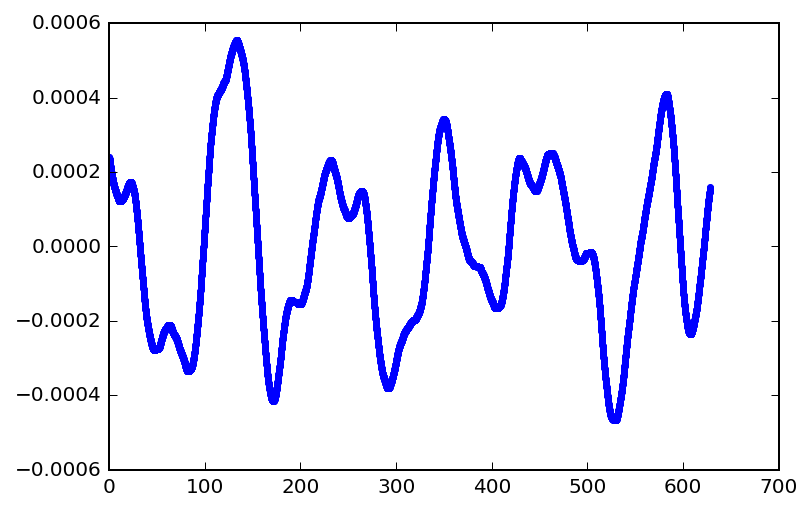

In [23]:
pca  = PCA()
pcatrans = pca.fit_transform(palsampleslampol)
print 'Explained variance by first 7:', np.sum(pca.explained_variance_ratio_[:7])
for i in range(7):
    plt.plot(tsamples, pcatrans[:,i], 'b.')
    plt.show()

#### Run Comparisons for different Time Scales and Number of Samples

In [24]:
tmaxlist = [5.0, 10.0, 50.0, 100.0, 500.0]
nsampleslist = [1000, 5000, 10000, 50000]
tru = False
if tru:
    for TX in tmaxlist:
        for NL in nsampleslist:
            tmax = TX*2.*np.pi
            Nsamples = NL
            tsamples = tmax*np.linspace(0,1, Nsamples, endpoint=False)
            sim = rebound.Simulation.from_file("ss.bin")
            palsamples = np.zeros((Nsamples,6*(N-1)))
            cartsamples = np.zeros((Nsamples,6*(N)))
            for i in range(Nsamples):
                sim.integrate(tsamples[i])
                palsamples[i] = sim_to_pal(sim)
                cartsamples[i] = sim_to_car(sim)

            palsampleslam = palsamples.copy()
            sim = rebound.Simulation.from_file("ss.bin")
            ns = np.zeros(N-1)
            lam0 = np.zeros(N-1)
            for j in range(1,N):
                ns[j-1] = sim.particles[j].n
                lam0[j-1] = palsamples[0,6*(j-1)+1]-ns[j-1]*tsamples[i]
            for i in range(Nsamples):
                for j in range(1,N):
                    palsampleslam[i,6*(j-1)+1] = mod2pi((palsamples[i,6*(j-1)+1]-lam0[j-1])-mod2pi(ns[j-1]*tsamples[i])+3.*np.pi)

            palsampleslampol = palsampleslam.copy()
            for i in range((N-1)*6):
                pol = np.polyfit(tsamples,palsampleslam[:,i],4)
                palsampleslampol[:,i] -= np.polyval(pol,tsamples)

            unmod = mean_pca_error_pal(palsamples)
            mod = mean_pca_error_pal(palsampleslam)
            modpol = mean_pca_error_pal(palsampleslampol)
            attrib = 'N:'+str(Nsamples)+', T:'+str(int(np.round(tmax/(2*np.pi))))+'yrs'
            np.save('Results/orig-'+attrib+'.npy', unmod)
            np.save('Results/lam-'+attrib+'.npy', mod)
            np.save('Results/pol-'+attrib+'.npy', modpol)
            plt.plot(tests, unmod, 'b.', tests, mod, 'g.', tests, modpol, 'r.')
            plt.yscale('log')
            plt.title('Mean Error in Pal Coordinates, '+ attrib)
            plt.ylabel('Mean Error')
            plt.xlabel('Number of PC Used')
            plt.legend(('Unmodified', 'Linearized Lambda', 'Removed O(4) Polynomial'), loc=3)
            plt.savefig('Plots/'+attrib+'.pdf')
            plt.show()

### Principal Component Analysis with FFT

In [28]:
tests = np.arange(1,49)
ntests = len(tests)
def mean_fftpca_error_pal(palpca, usewindow=False):
    palpcaFFT = np.zeros(palpca.shape, dtype=complex)
    postpcaFFT = palpcaFFT.copy()
    postpca = palpcaFFT.copy()
    if usewindow:
        window = np.hanning(Nsamples)
    else:
        window = np.ones(Nsamples)
    for i in range((N-1)*6):
        palpcaFFT[:,i] = np.fft.fft(palpca[:,i]*window)
    pcareal = PCA()
    pcaimag = PCA()
    palpcaFFTtransreal = pcareal.fit_transform(np.real(palpcaFFT))
    palpcaFFTtransimag = pcaimag.fit_transform(np.imag(palpcaFFT))
    pca = PCA()
    palpcatrans = pca.fit_transform(palpca)
    mureal = np.mean(np.real(palpcaFFT), axis=0)
    muimag = np.mean(np.imag(palpcaFFT), axis=0)
    meanmet = np.zeros(ntests)
    
    for j,nComp in enumerate(tests):
        Xhatreal = np.dot(palpcaFFTtransreal[:,:nComp], pcareal.components_[:nComp,:])
        Xhatimag = np.dot(palpcaFFTtransimag[:,:nComp], pcaimag.components_[:nComp,:])
        Xhatreal += mureal
        Xhatimag += muimag
        postpcaFFT = Xhatreal + 1j*Xhatimag
        for k in range((N-1)*6):
            postpca[:,k] = np.fft.ifft(postpcaFFT[:,k])
        diff = np.absolute(palpca - postpca)
        meanmet[j] = np.mean(np.mean(diff, axis=1))
    return meanmet

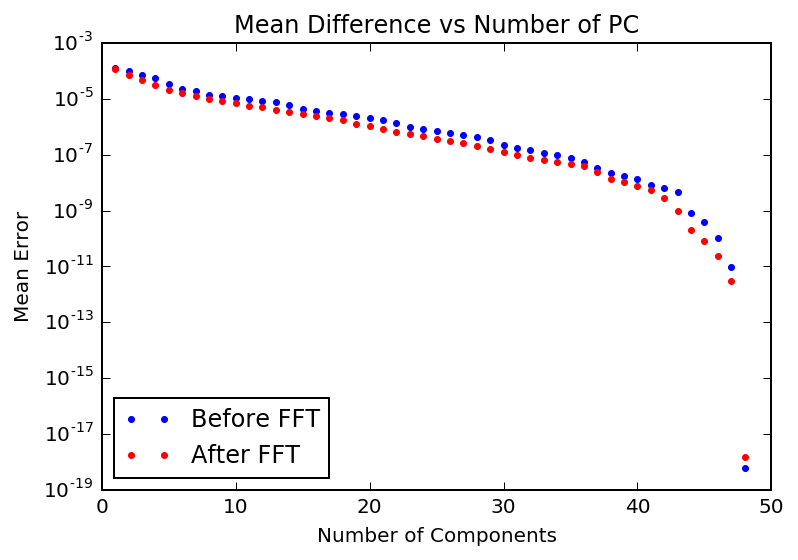

In [29]:
res = mean_pca_error_pal(palsampleslampol)
re2 = mean_fftpca_error_pal(palsampleslampol)

plt.plot(tests, res, 'b.', tests, re2, 'r.')
plt.title('Mean Difference vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Mean Error')
plt.legend(('Before FFT', 'After FFT'), loc=3)
plt.show()

#### Details

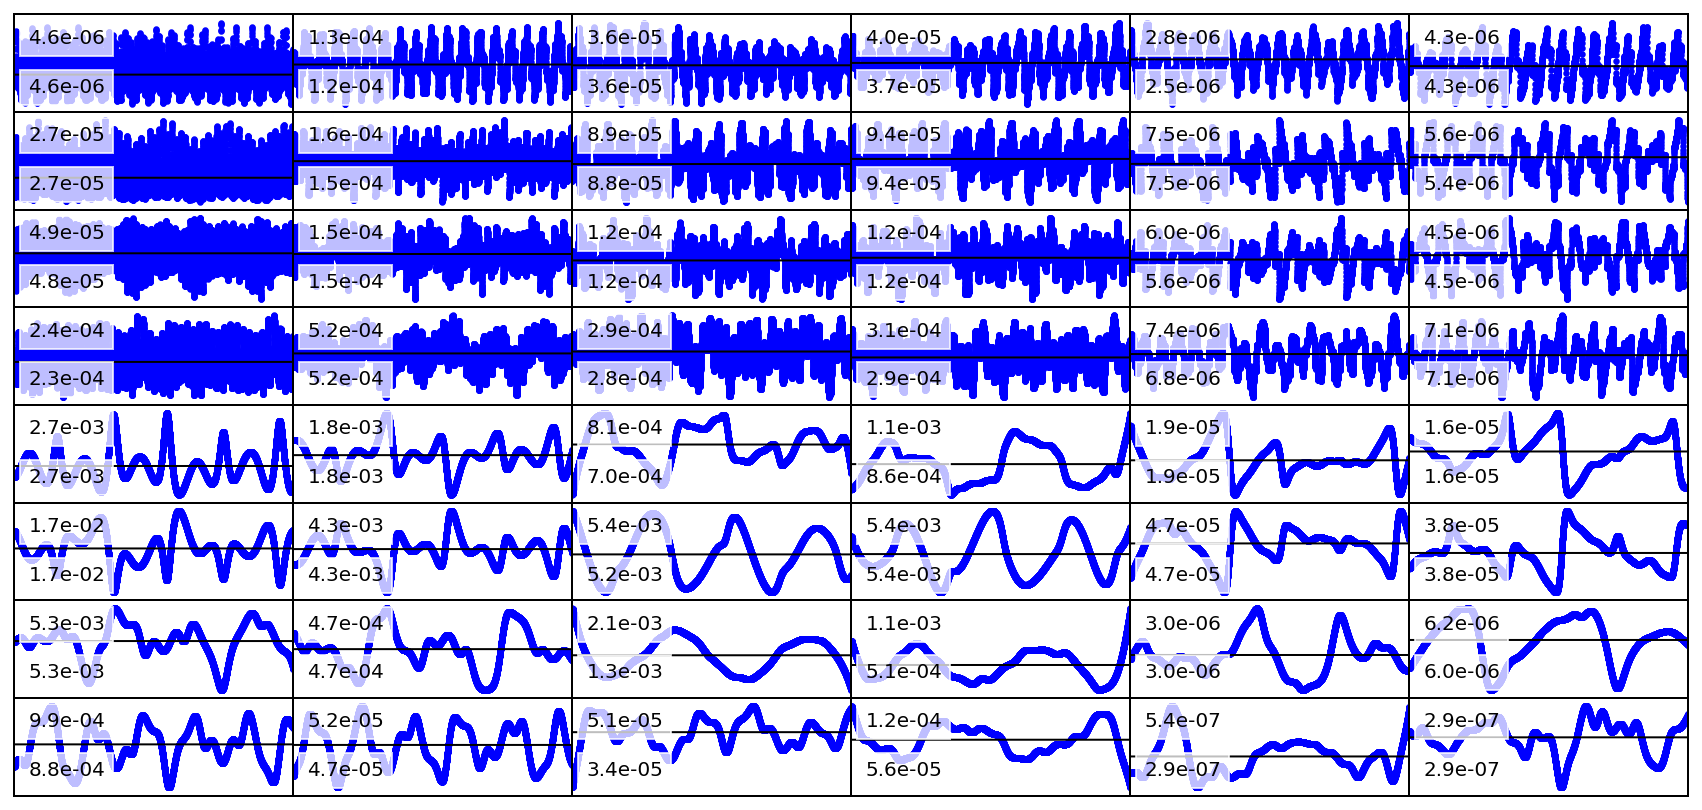

In [22]:
palsampleslampolfft = palsampleslampol.copy()
palsamplesFFT = np.zeros(palsampleslampolfft.shape, dtype=complex)
plot_pal(tsamples, palsampleslampolfft)

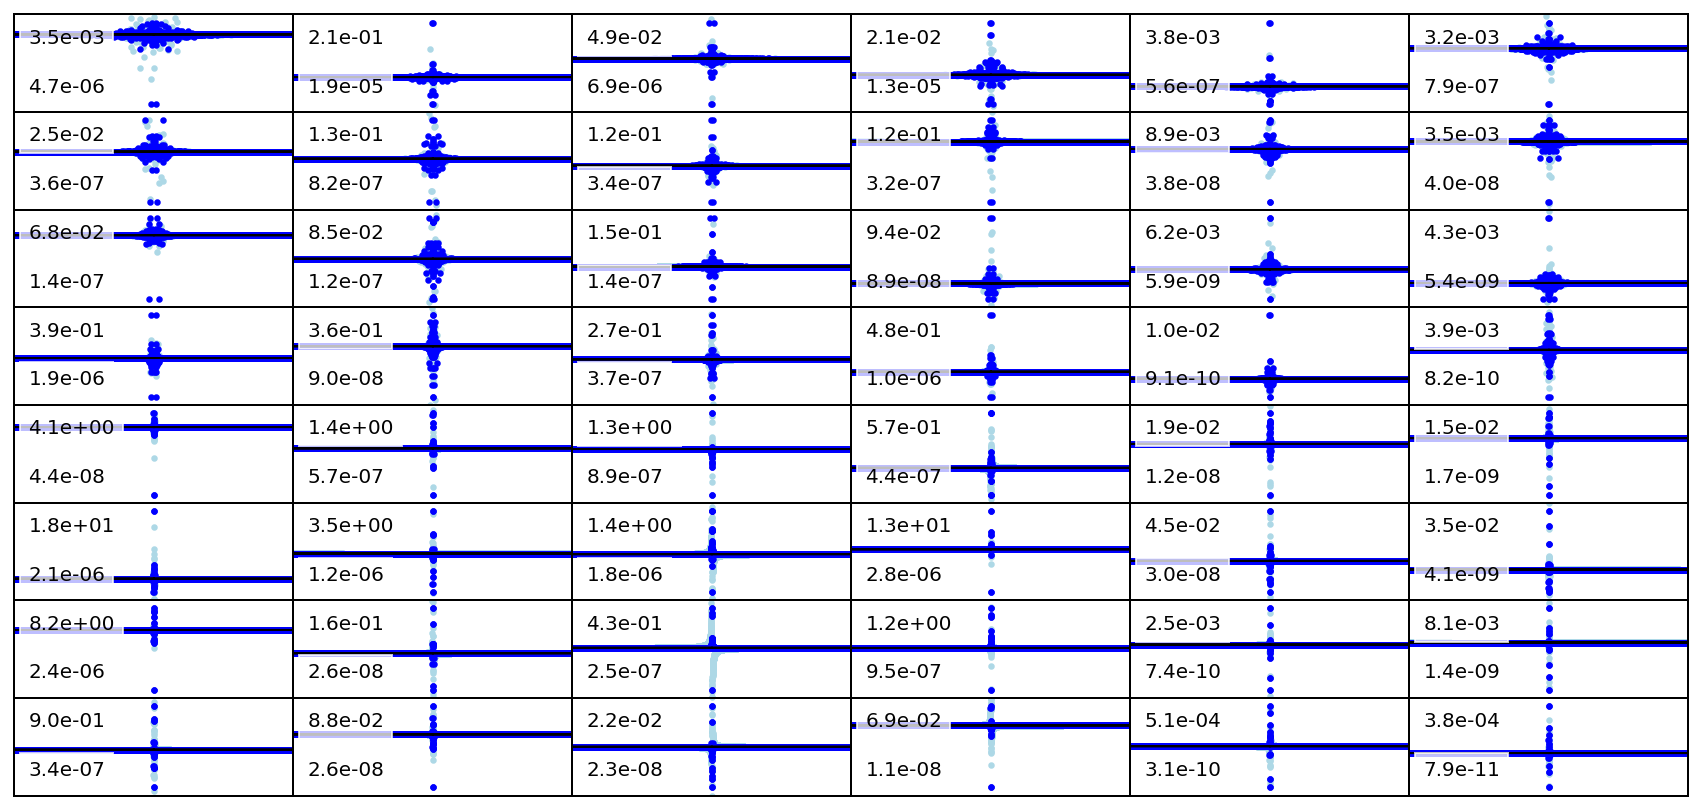

In [53]:
freqs = np.fft.fftfreq(len(tsamples), d=(tsamples[-1]/len(tsamples)))
# window = np.hanning(Nsamples)
for i in range((N-1)*6):
    palsamplesFFT[:,i] = np.fft.fft(palsampleslampolfft[:,i])
plot_pal(freqs, np.real(palsamplesFFT), np.imag(palsamplesFFT))

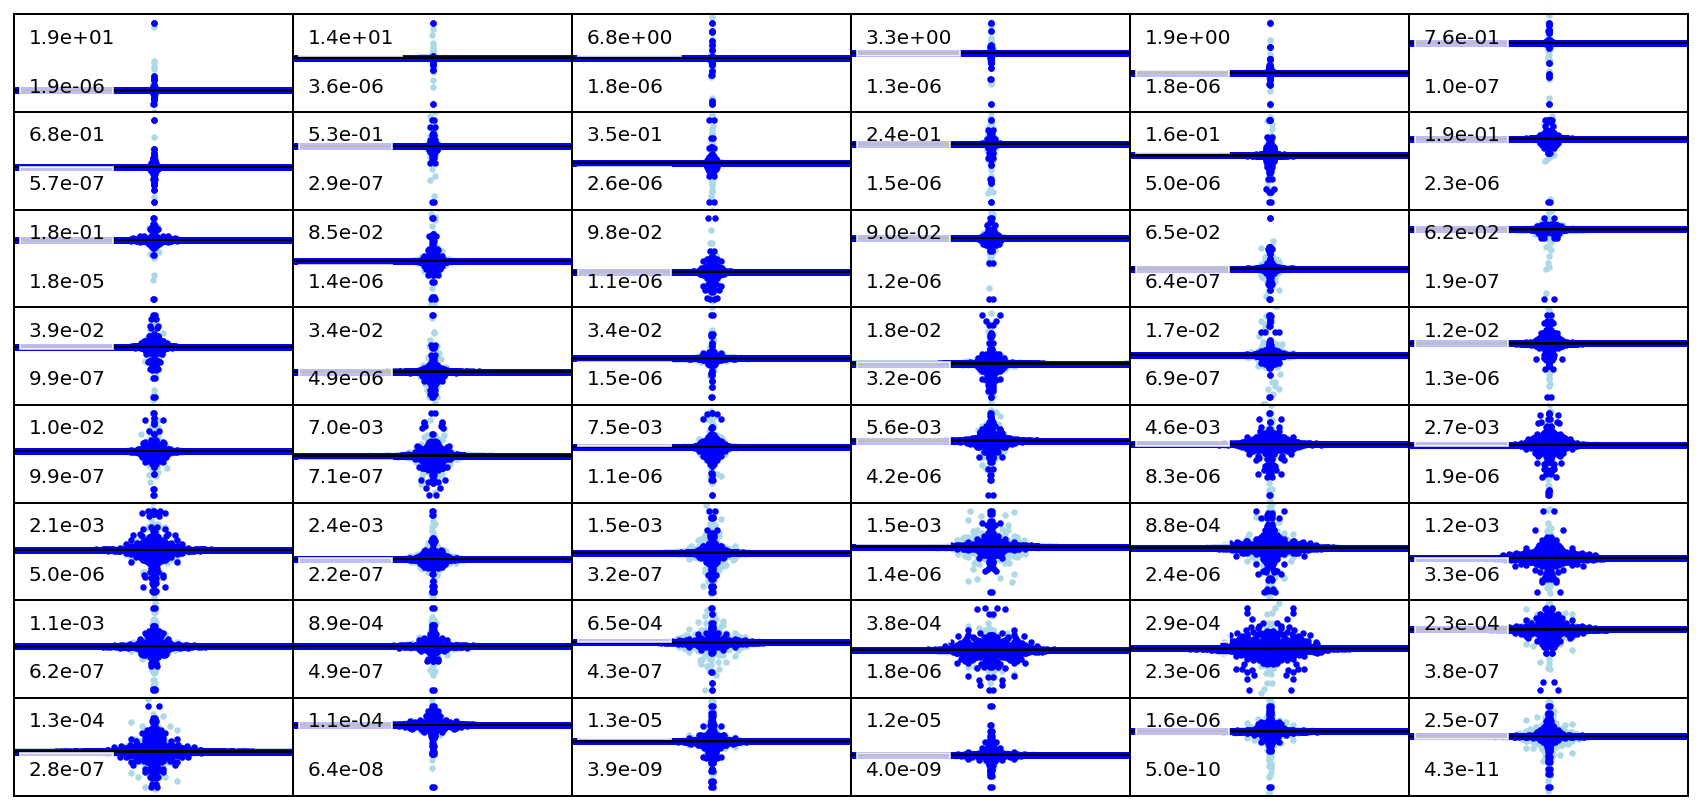

In [26]:
pcareal = PCA()
pcaimag = PCA()
transreal = pcareal.fit_transform(np.real(palsamplesFFT))
transimag = pcaimag.fit_transform(np.imag(palsamplesFFT))
plot_pal(freqs, transreal, transimag)

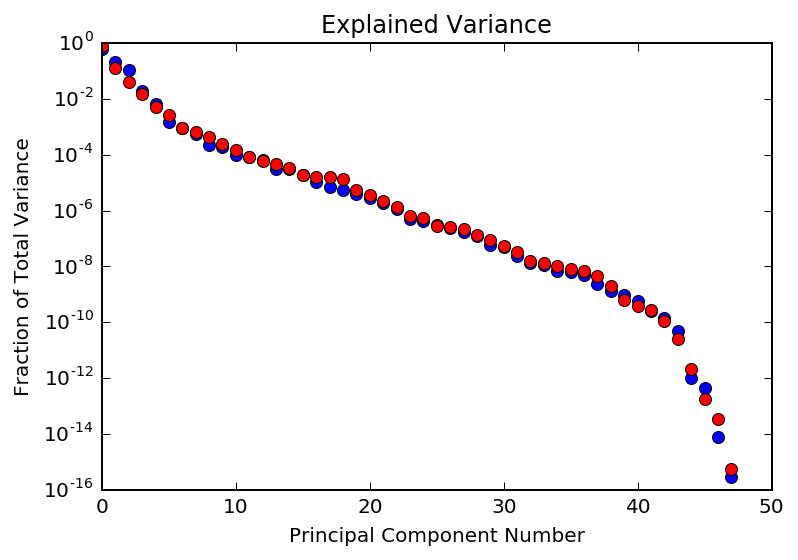

In [27]:
plt.plot(range(48), pcareal.explained_variance_ratio_, 'bo', range(48), pcaimag.explained_variance_ratio_, 'ro')
plt.yscale('log')
plt.title('Explained Variance')
plt.ylabel('Fraction of Total Variance')
plt.xlabel('Principal Component Number')
plt.show()

### PCA with Modified FFT

#### Scalar Products

In [30]:
def sp(a,b):
    return 2.*np.sum(a*np.conjugate(b)*window)/(Nsamples-1);
def amp(sigma):
    return sp(ffft,np.exp(1j*sigma*tsamples))
def ob(sigma):
    return -np.abs(amp(sigma))

#### Remove first 10 and 100 harmonics using Modified FFT

In [35]:
palsampleslampolfftreal = palsampleslampol.copy()
window = np.hanning(Nsamples)
nyq = 2.*np.pi/tmax
for k in range(10):
    for i in range((N-1)*6):
        ffft = palsampleslampolfftreal[:,i]
        ki = np.argmax(np.abs(np.fft.rfft(ffft*window)))
        f0 = np.fft.rfftfreq(Nsamples,d=tmax/Nsamples)[ki]*2.*np.pi
        res = scipy.optimize.minimize(ob,(f0),bounds=((f0-nyq,f0+nyq),),tol=1e-9)
        f0 = res["x"][0]
        A = amp(f0)
        palsampleslampolfftreal[:,i] -= 2.*np.real(A*np.exp(1j*f0*tsamples))

palsampleslampolfftreal100 = palsampleslampol.copy()
window = np.hanning(Nsamples)
nyq = 2.*np.pi/tmax
for k in range(100):
    for i in range((N-1)*6):
        ffft = palsampleslampolfftreal100[:,i]
        ki = np.argmax(np.abs(np.fft.rfft(ffft*window)))
        f0 = np.fft.rfftfreq(Nsamples,d=tmax/Nsamples)[ki]*2.*np.pi
        res = scipy.optimize.minimize(ob,(f0),bounds=((f0-nyq,f0+nyq),),tol=1e-9)
        f0 = res["x"][0]
        A = amp(f0)
        palsampleslampolfftreal100[:,i] -= 2.*np.real(A*np.exp(1j*f0*tsamples))

In [47]:
un = mean_pca_error_pal(palsampleslam)
res = mean_pca_error_pal(palsampleslampol)
re2 = mean_pca_error_pal(palsampleslampolfftreal)
re3 = mean_pca_error_pal(palsampleslampolfftreal100)

resfft = mean_fftpca_error_pal(palsampleslampol)
resmdfft = mean_fftpca_error_pal(palsampleslampolfftreal)
resmdfft100 = mean_fftpca_error_pal(palsampleslampolfftreal100)

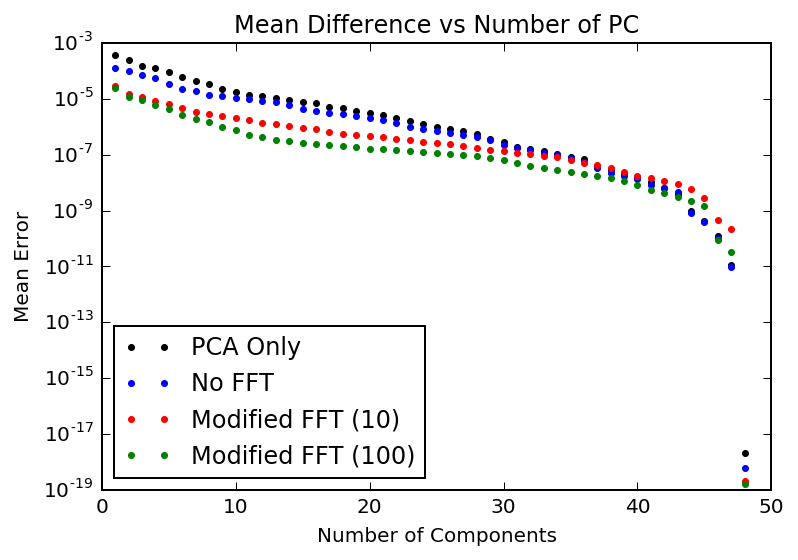

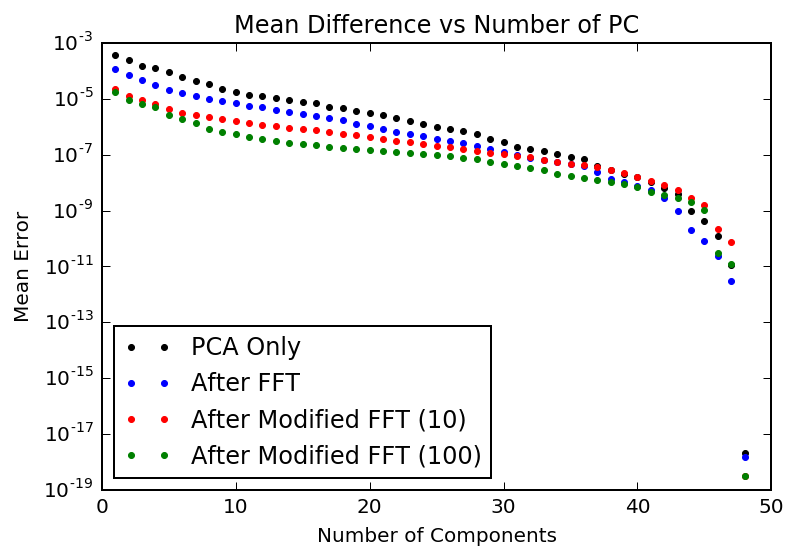

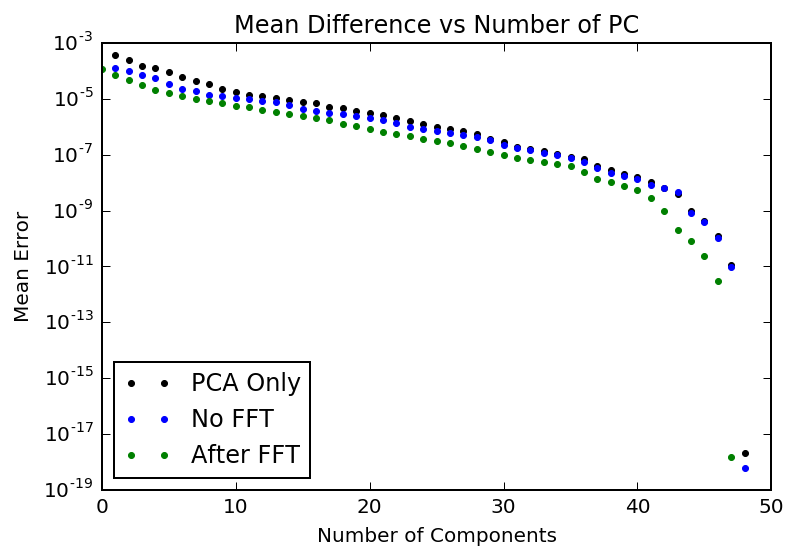

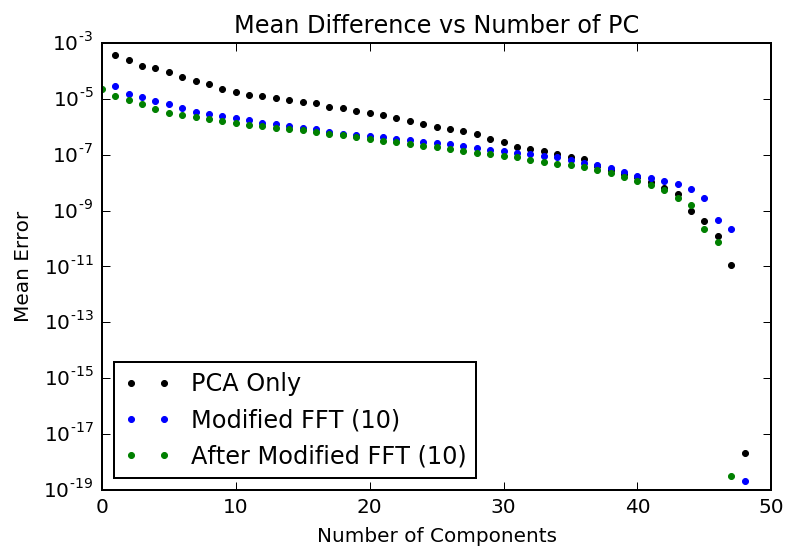

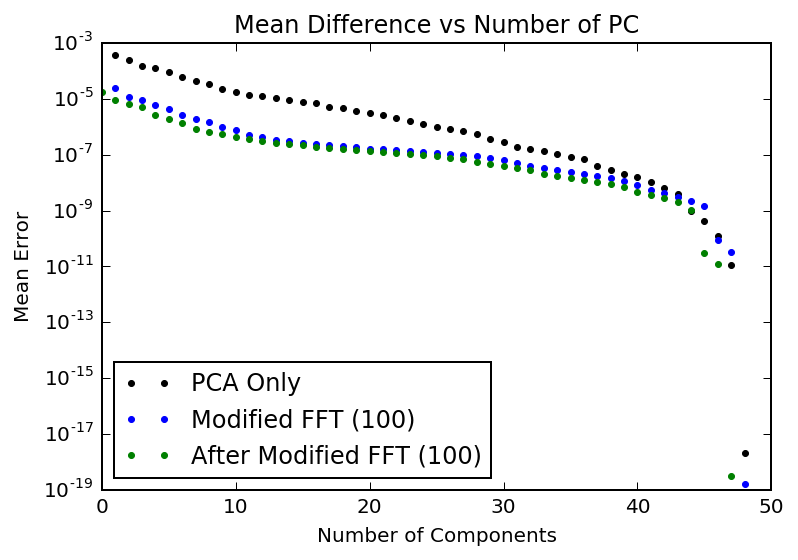

In [49]:
plt.plot(tests, un, 'k.', tests, res, 'b.', tests, re2, 'r.', tests, re3, 'g.')
plt.title('Mean Difference vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Mean Error')
plt.legend(('PCA Only', 'No FFT', 'Modified FFT (10)', 'Modified FFT (100)'), loc=3)
plt.show()

plt.plot(tests, un, 'k.', tests, resfft, 'b.', tests, resmdfft, 'r.', tests, resmdfft100, 'g.')
plt.title('Mean Difference vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Mean Error')
plt.legend(('PCA Only', 'After FFT', 'After Modified FFT (10)', 'After Modified FFT (100)'), loc=3)
plt.show()

plt.plot(tests, un, 'k.', tests, res, 'b.', resfft, 'g.')
plt.title('Mean Difference vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Mean Error')
plt.legend(('PCA Only', 'No FFT', 'After FFT'), loc=3)
plt.show()

plt.plot(tests, un, 'k.', tests, re2, 'b.', resmdfft, 'g.')
plt.title('Mean Difference vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Mean Error')
plt.legend(('PCA Only', 'Modified FFT (10)', 'After Modified FFT (10)'), loc=3)
plt.show()

plt.plot(tests, un, 'k.', tests, re3, 'b.', resmdfft100, 'g.')
plt.title('Mean Difference vs Number of PC')
plt.yscale('log')
plt.xlabel('Number of Components')
plt.ylabel('Mean Error')
plt.legend(('PCA Only', 'Modified FFT (100)', 'After Modified FFT (100)'), loc=3)
plt.show()

### Spectrogram of Pal Coordinates

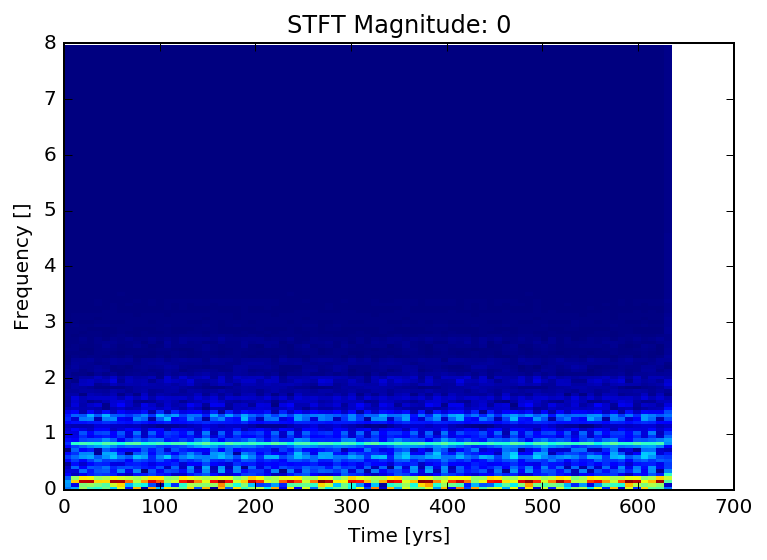

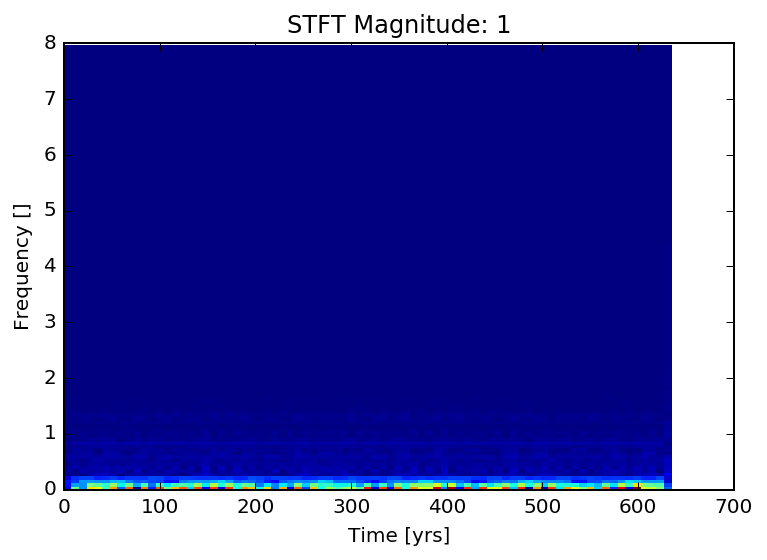

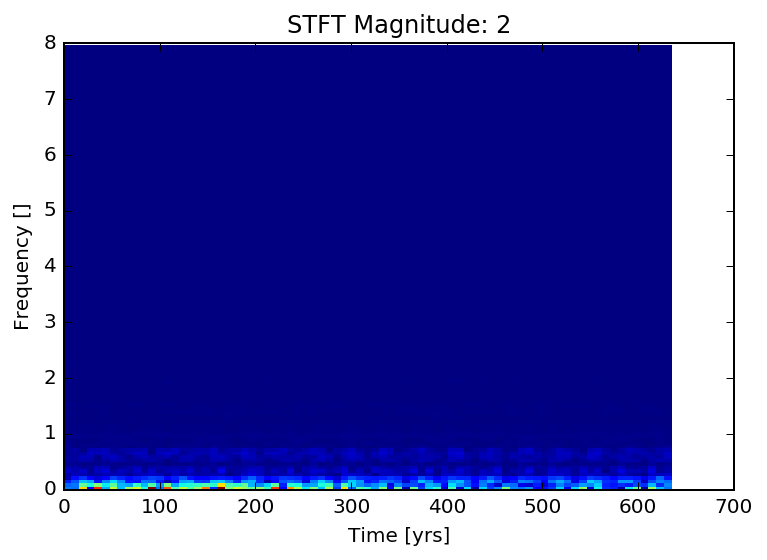

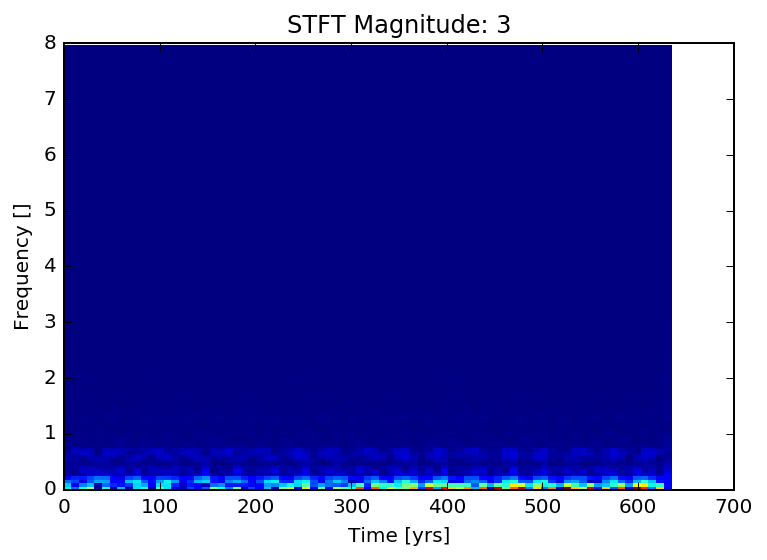

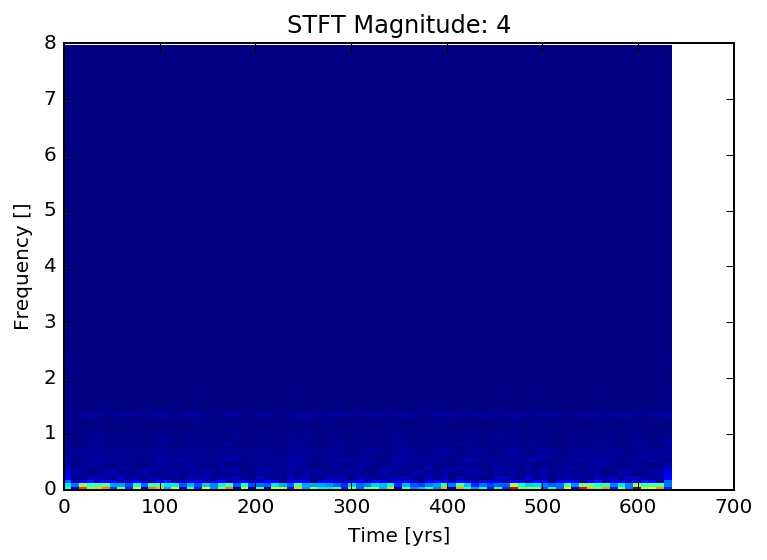

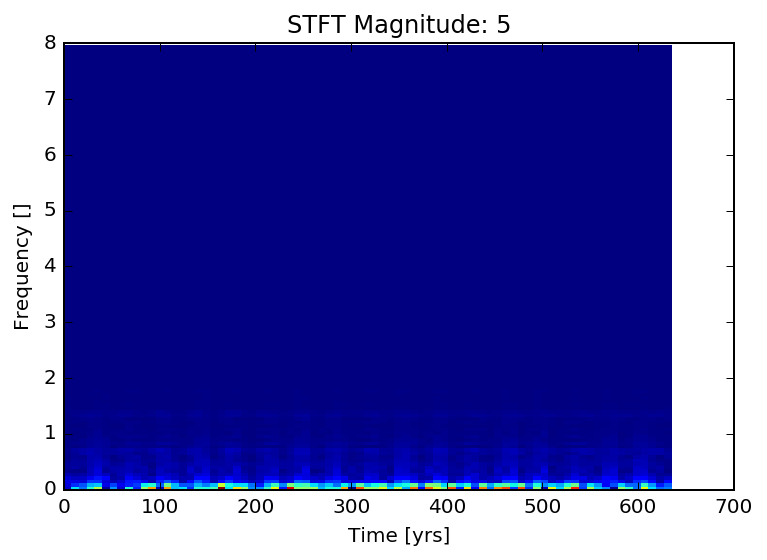

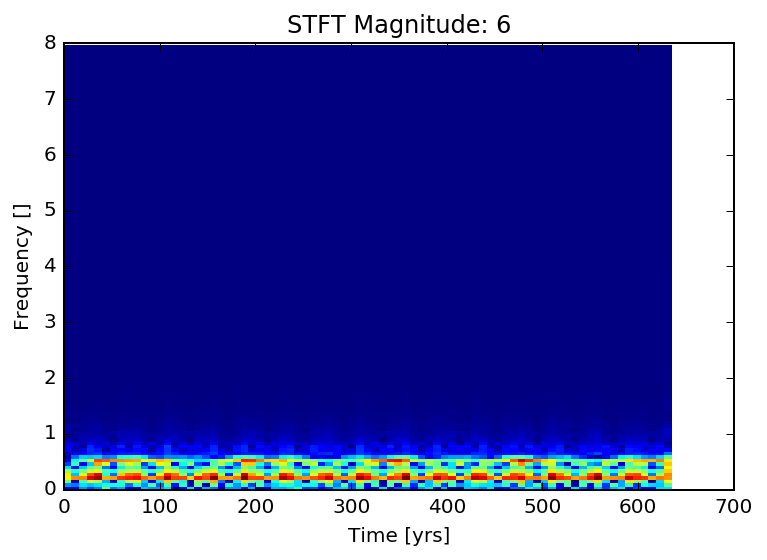

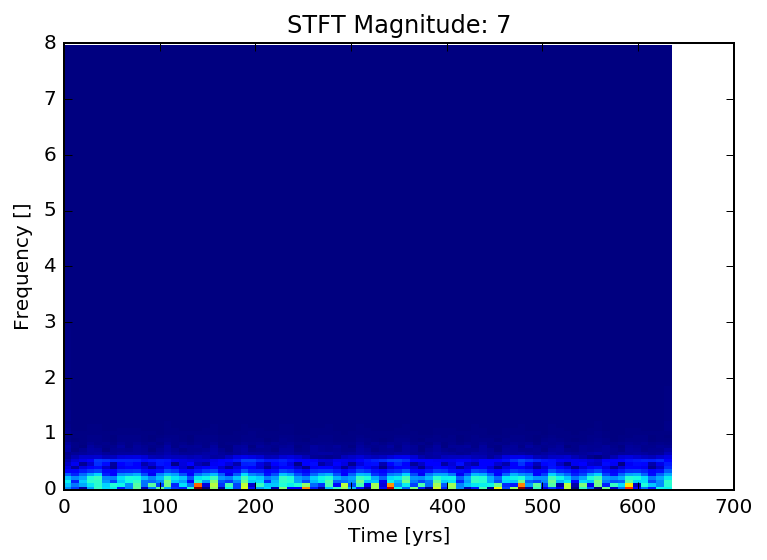

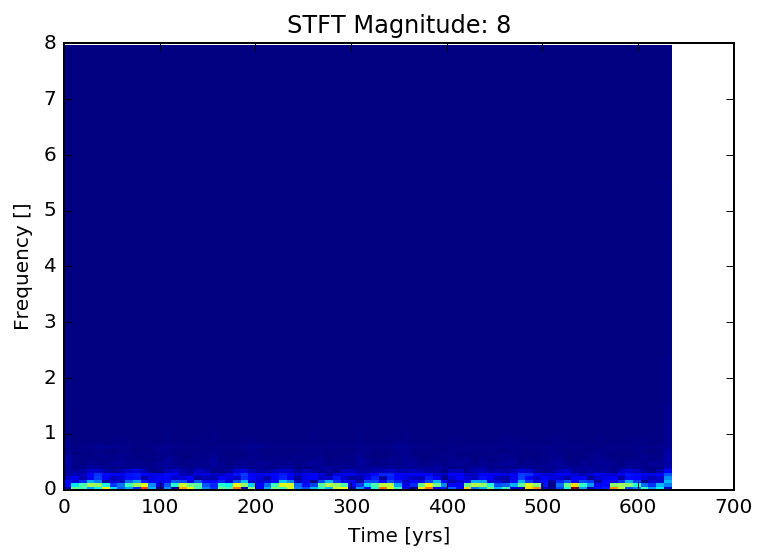

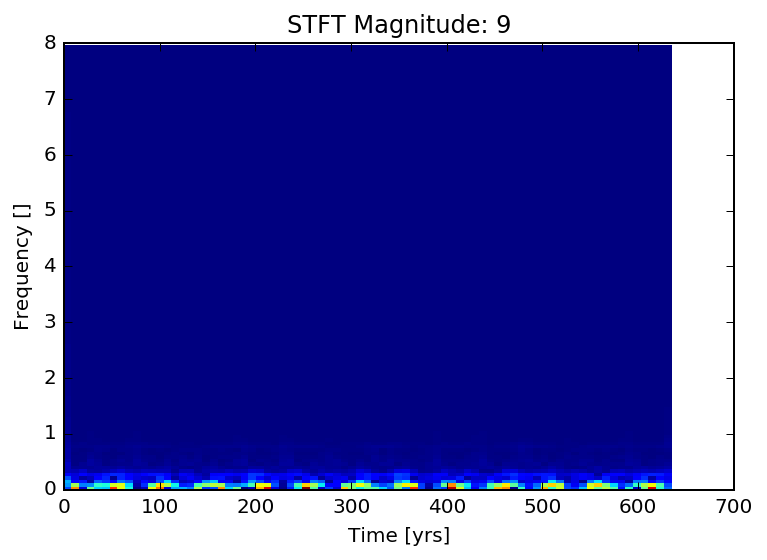

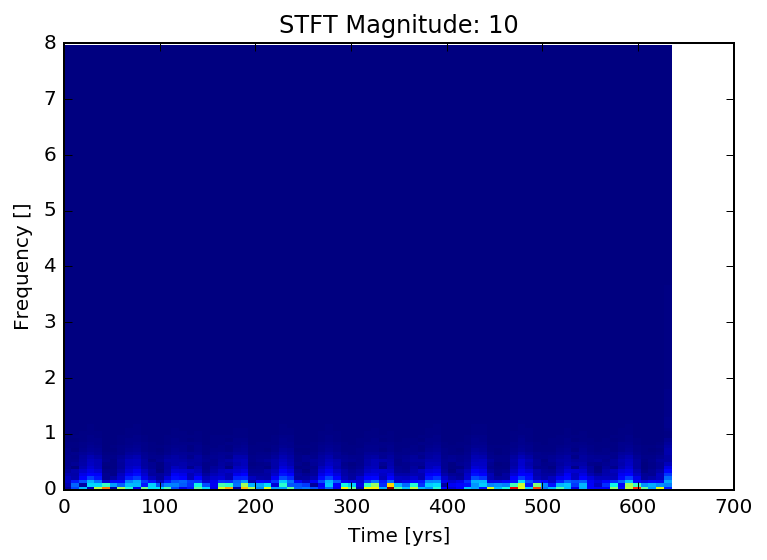

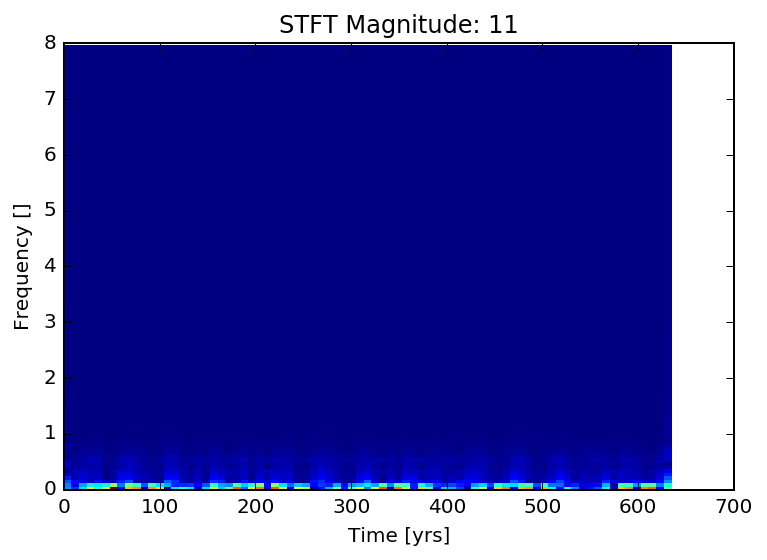

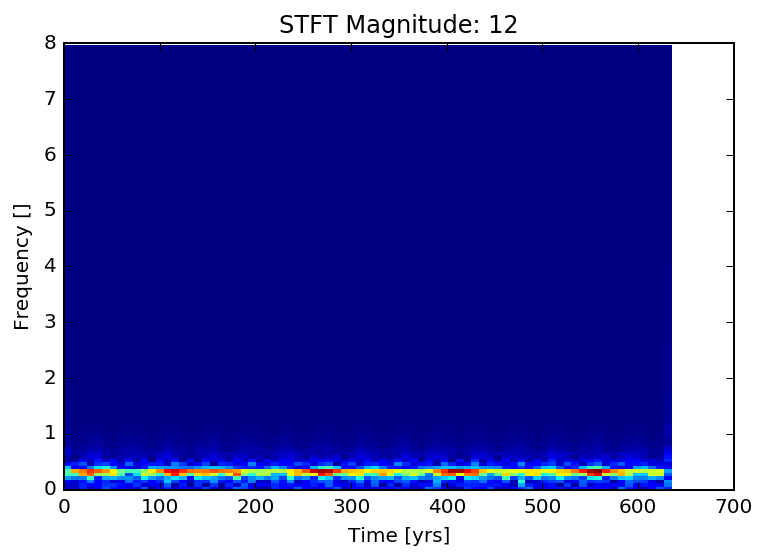

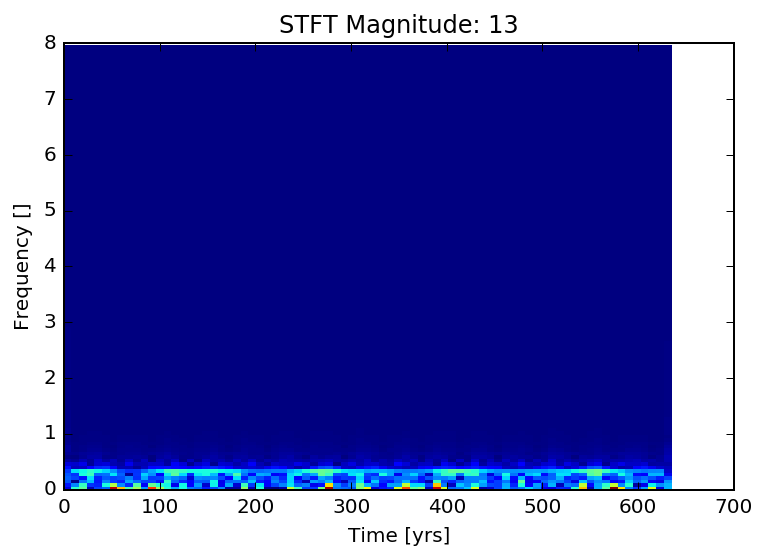

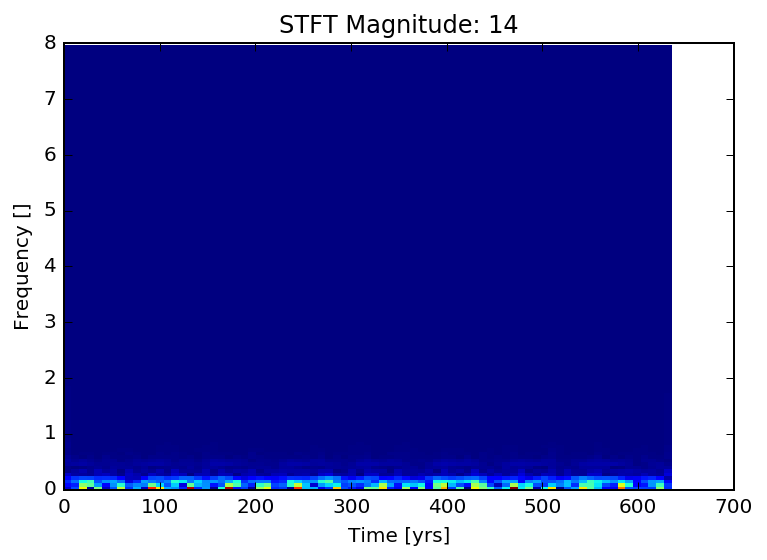

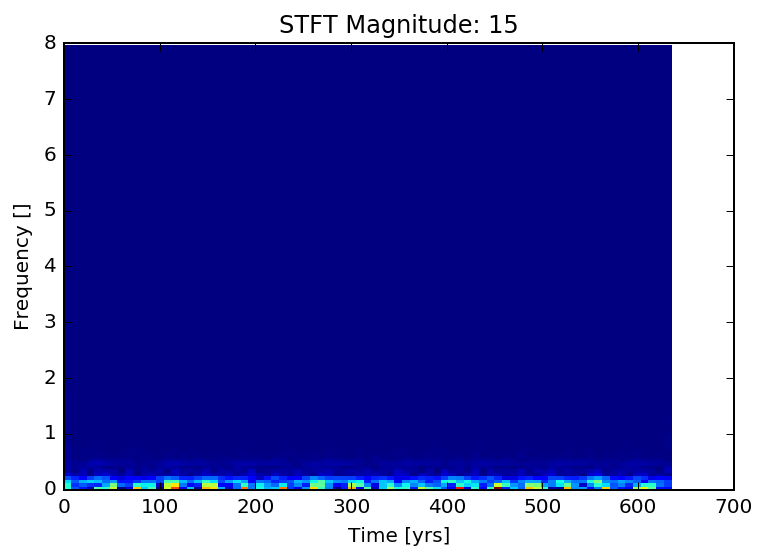

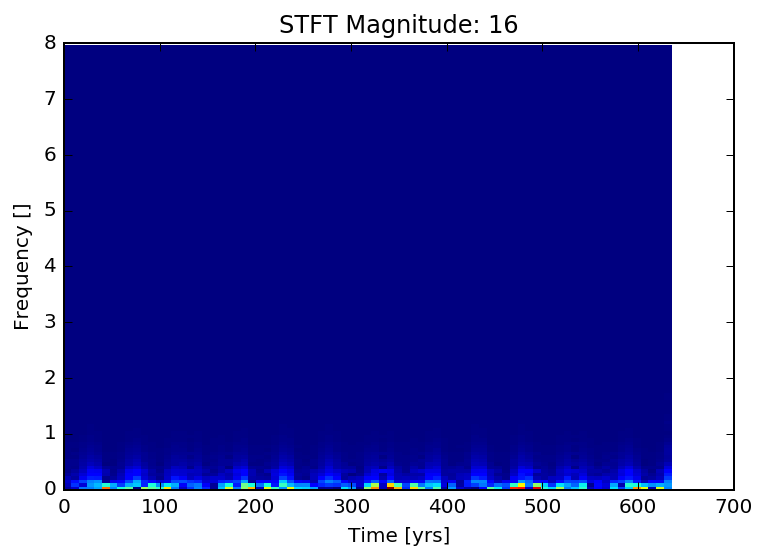

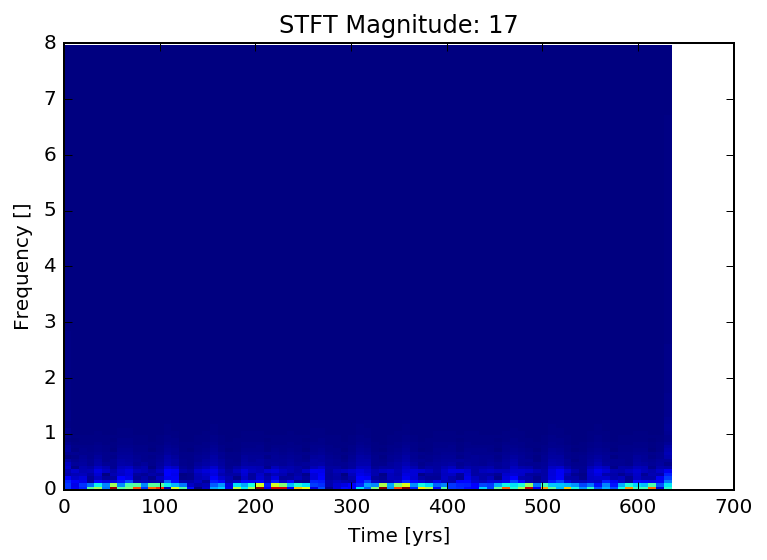

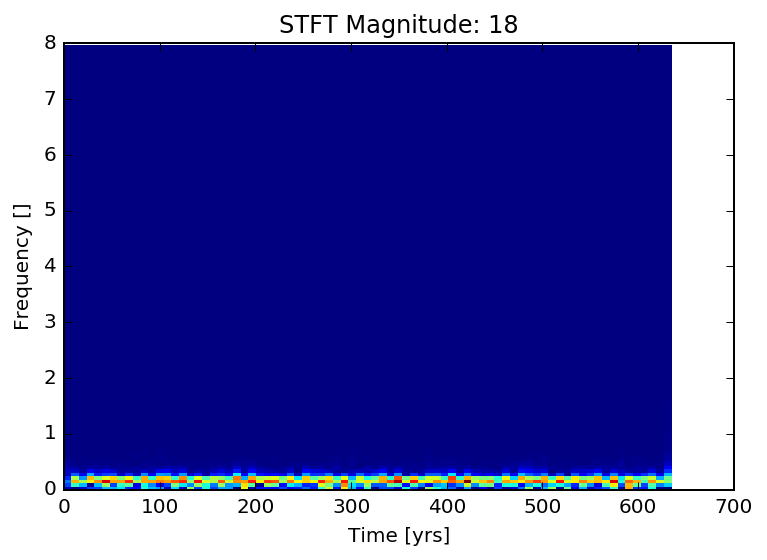

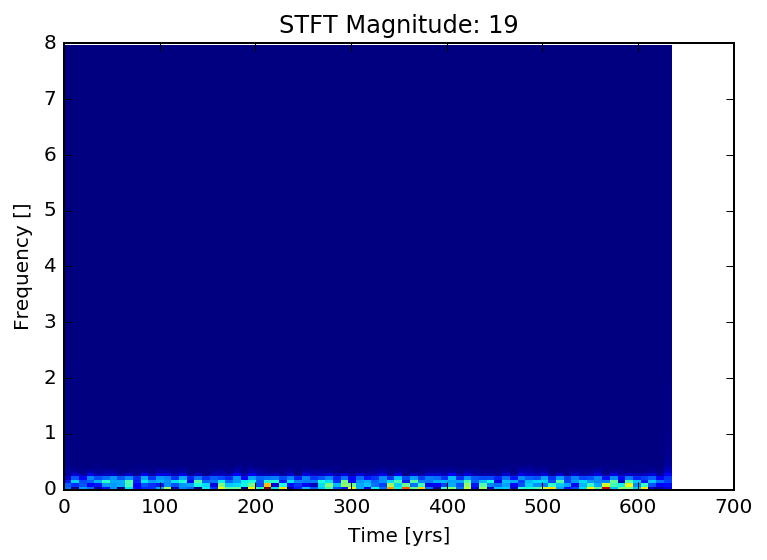

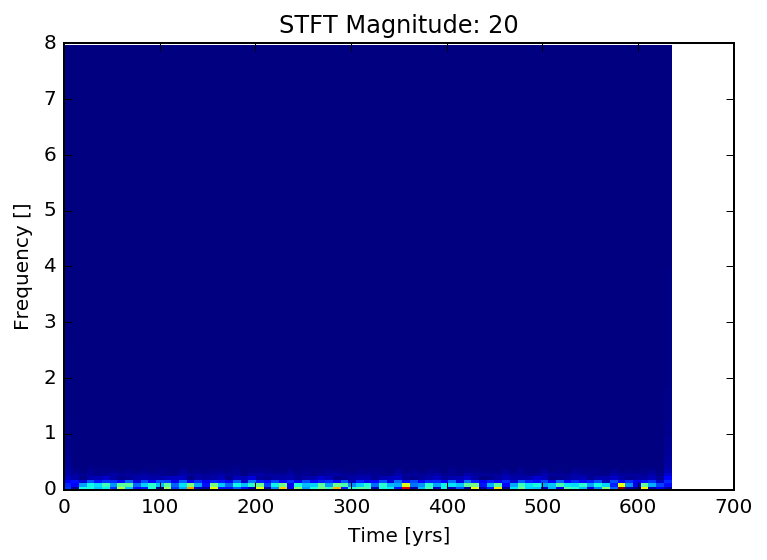

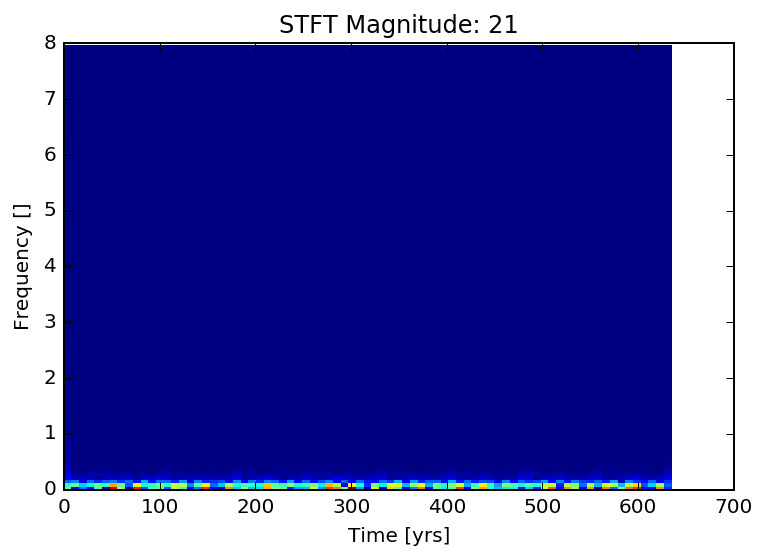

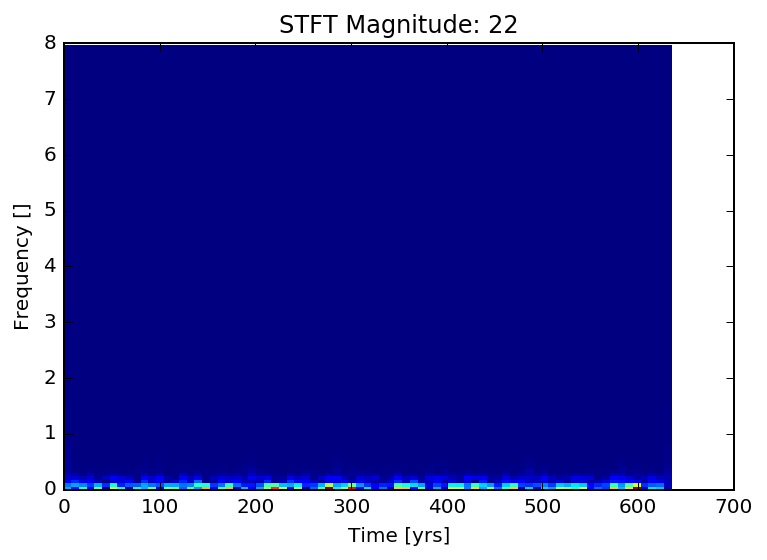

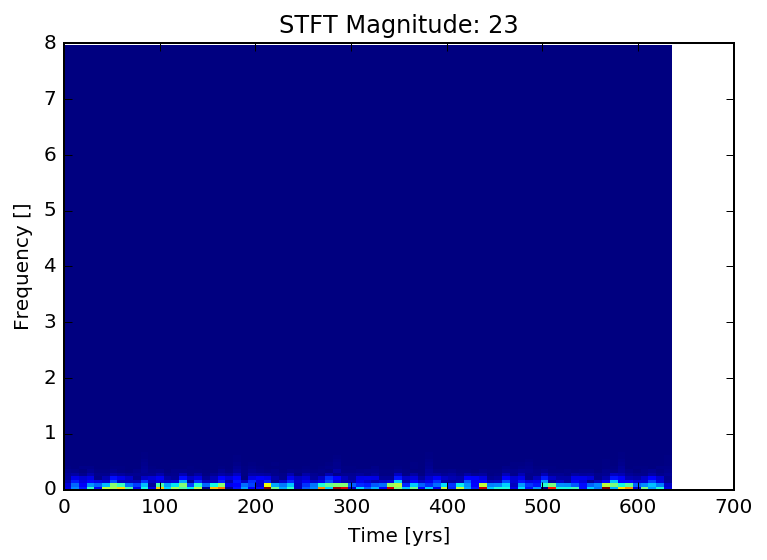

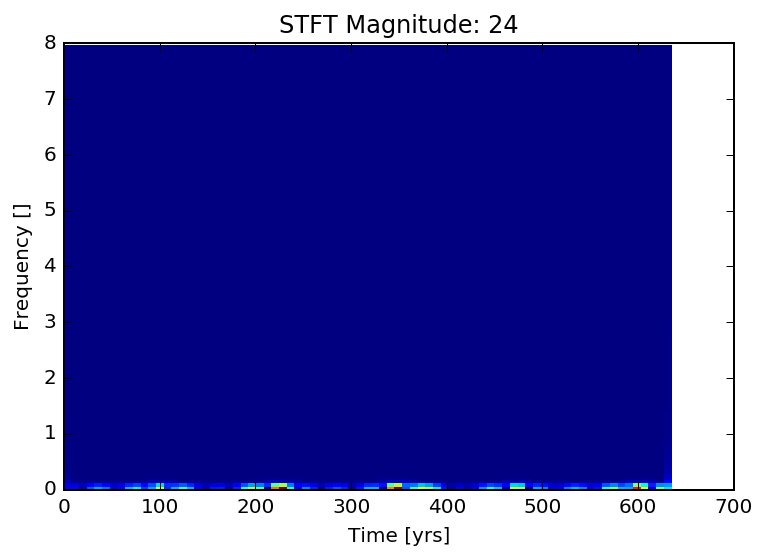

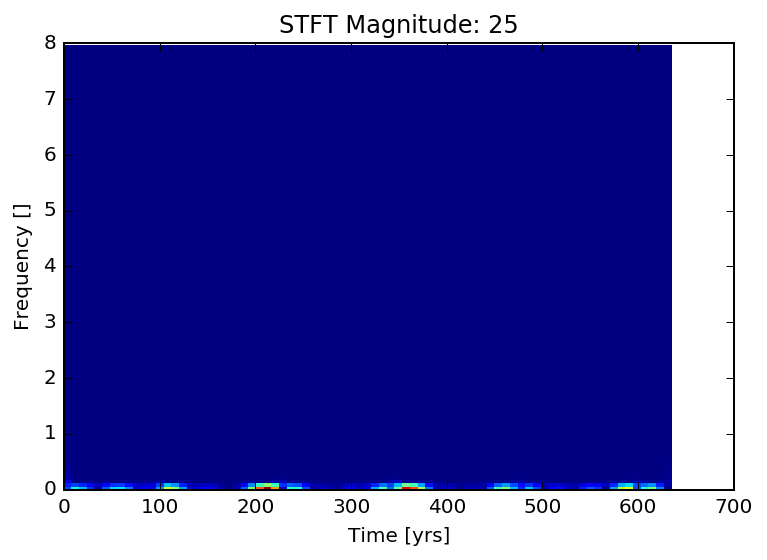

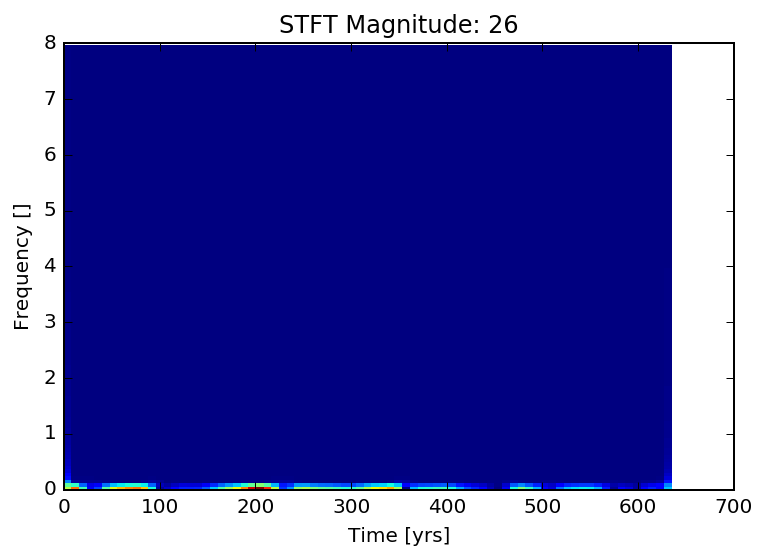

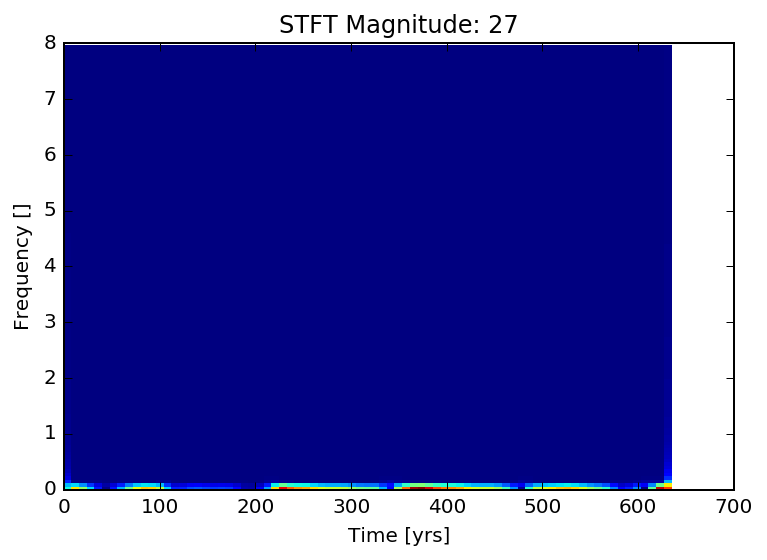

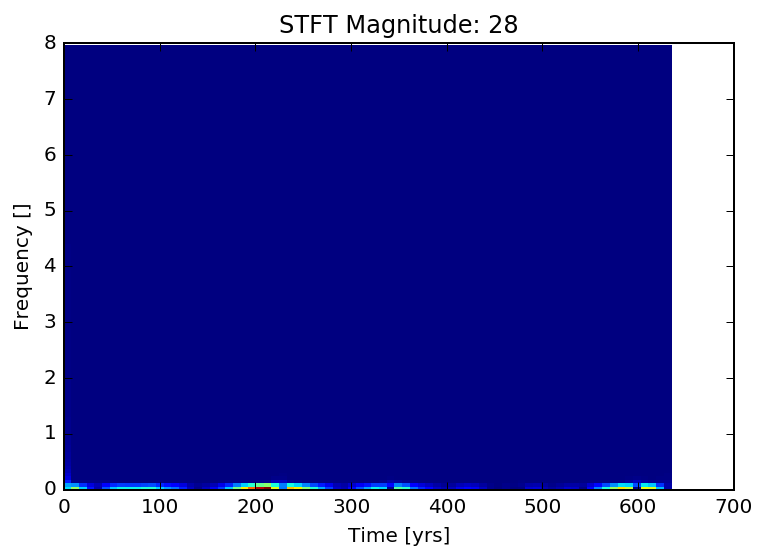

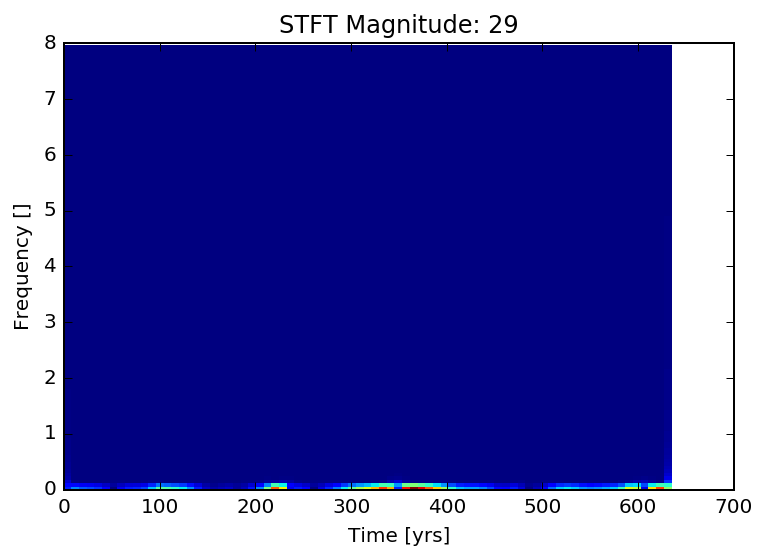

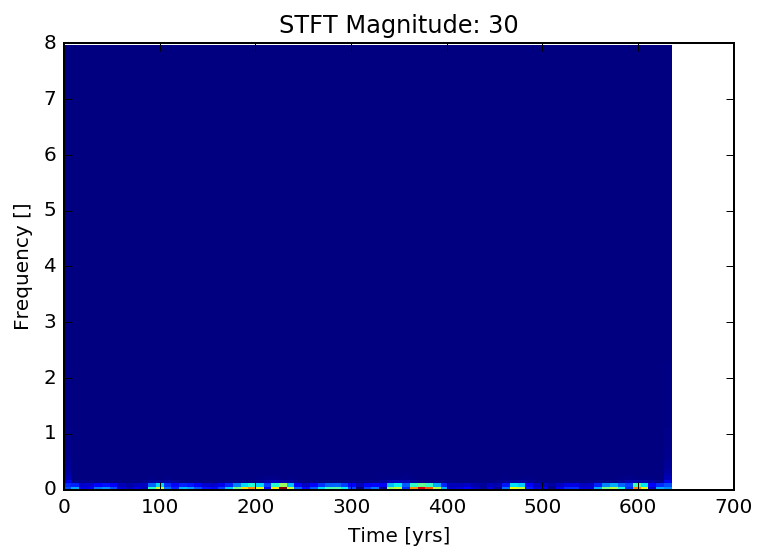

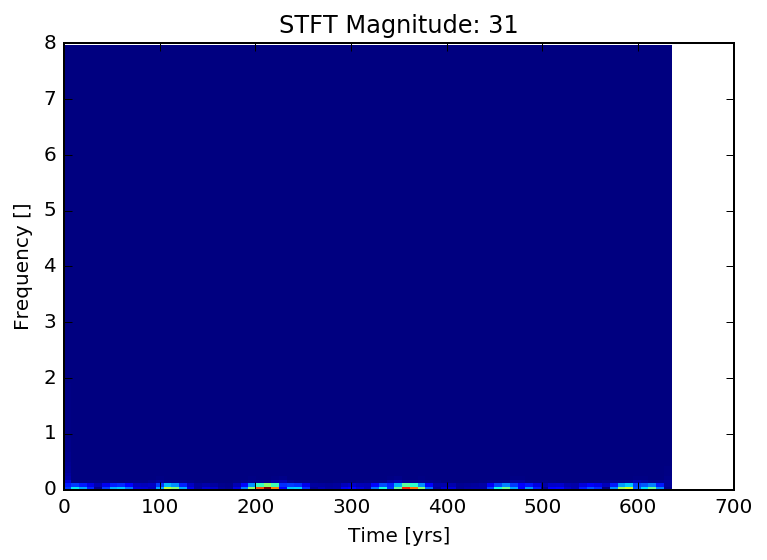

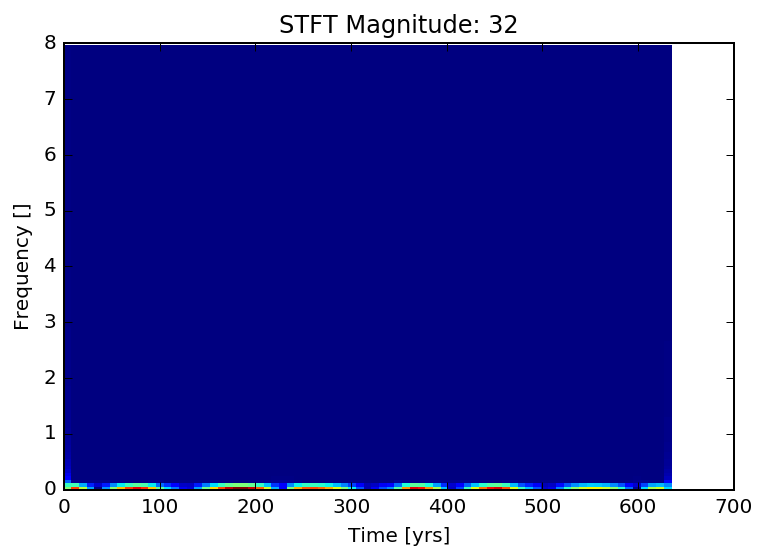

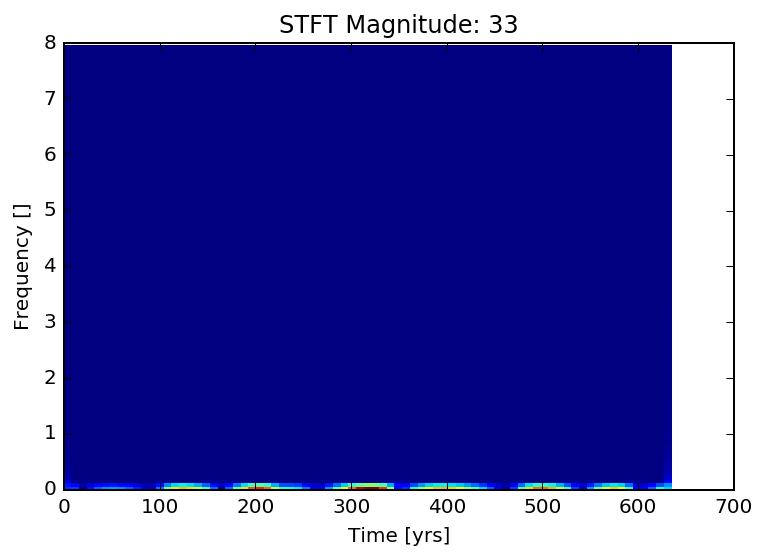

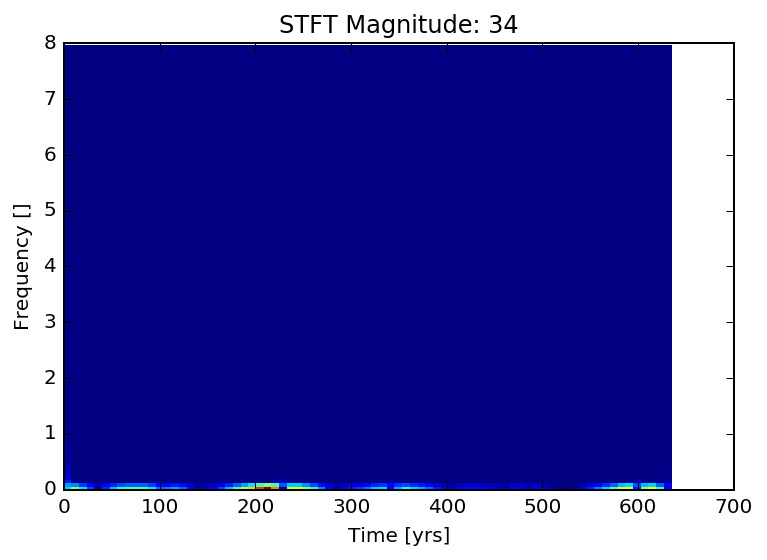

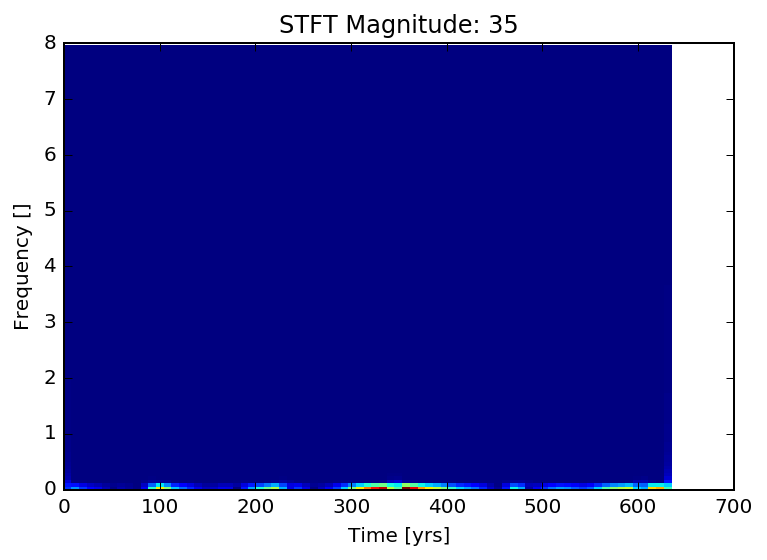

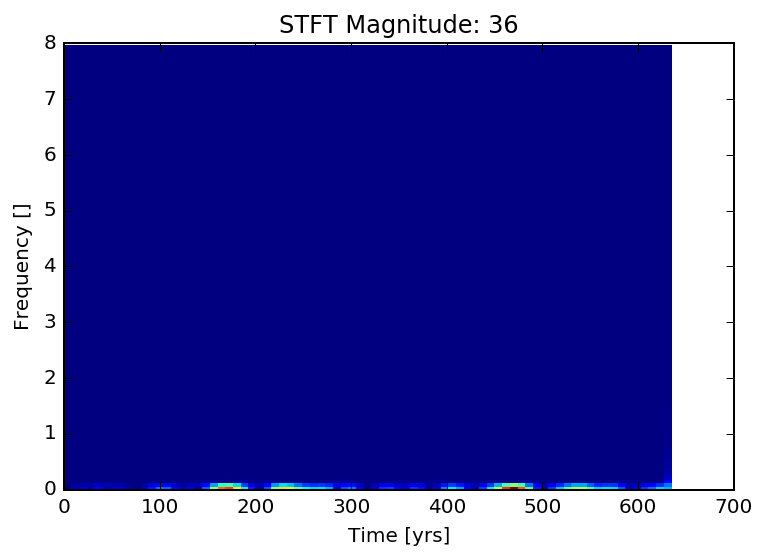

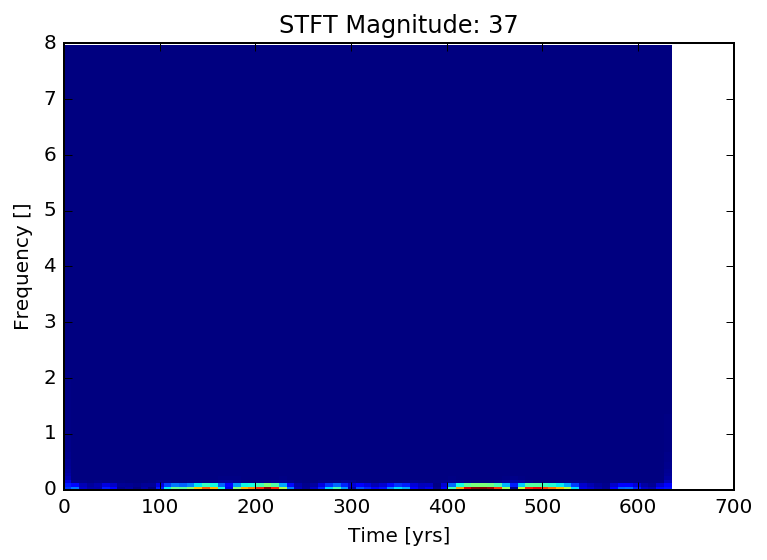

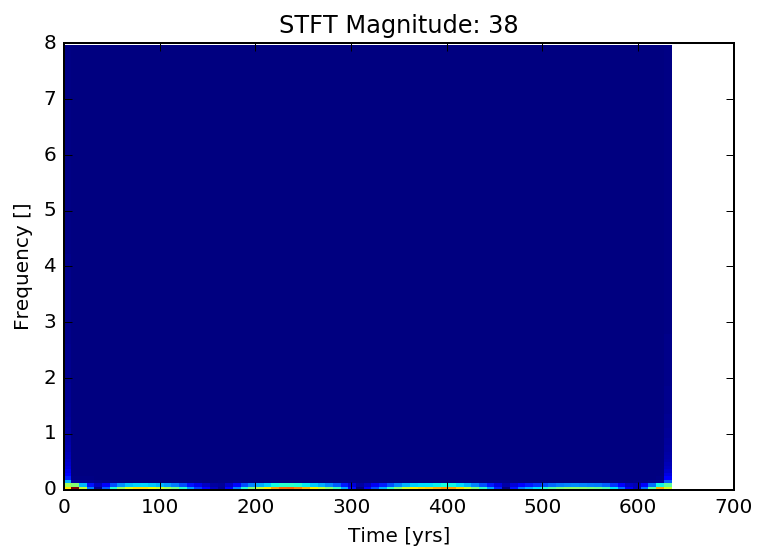

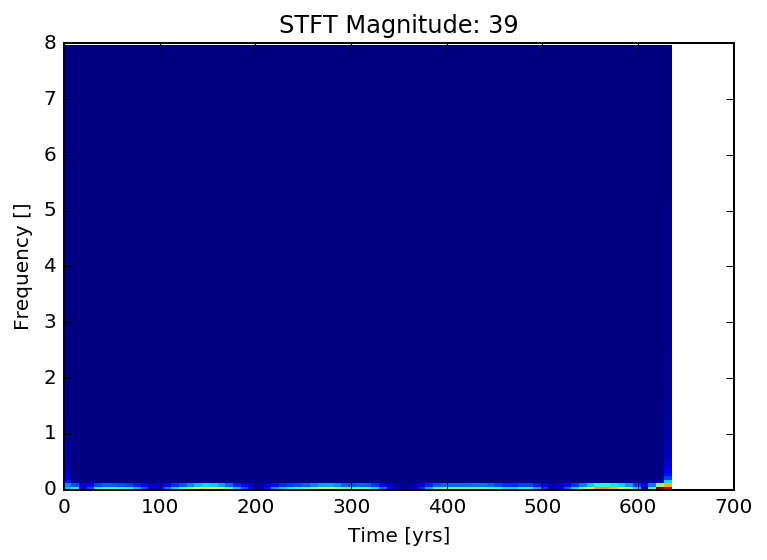

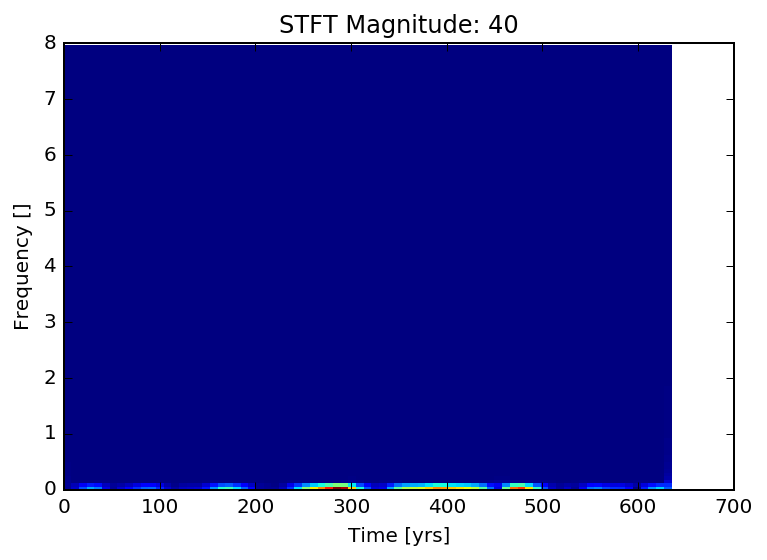

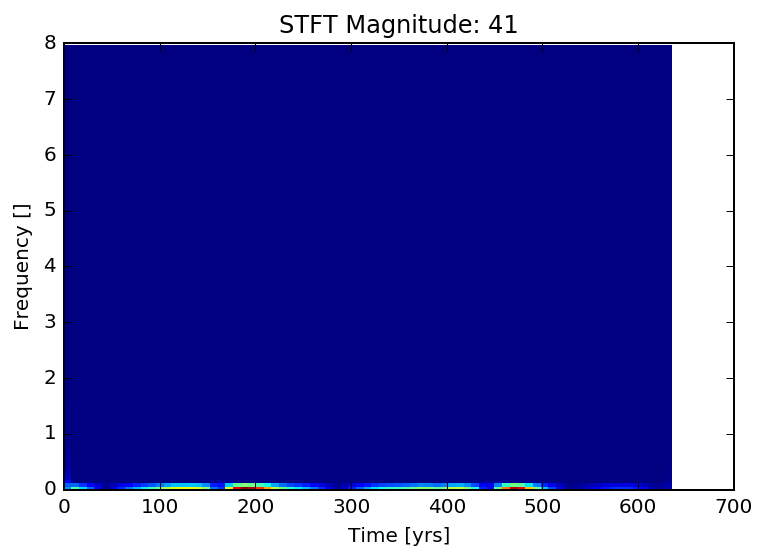

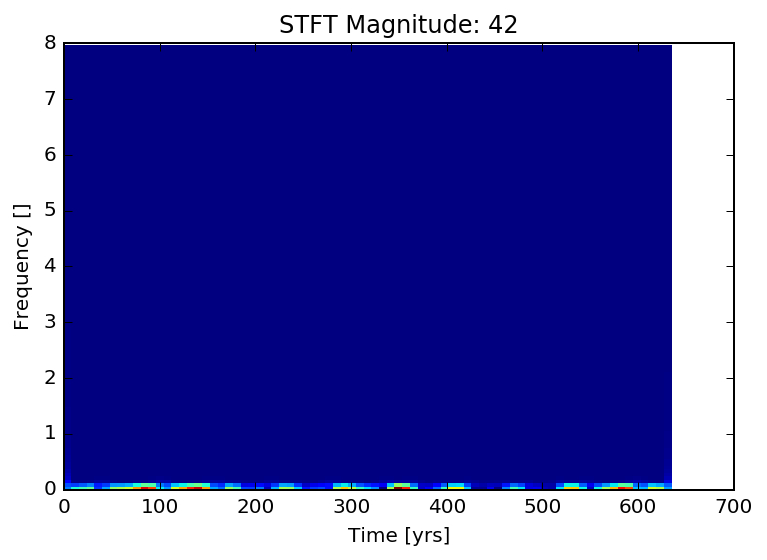

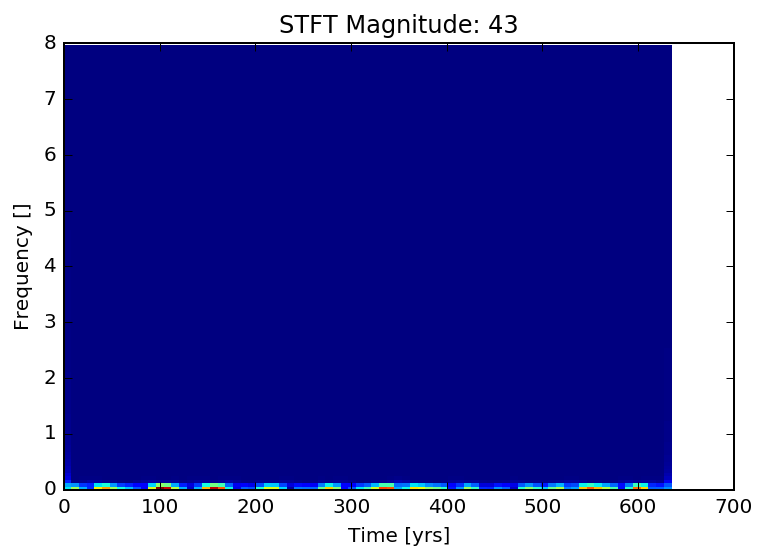

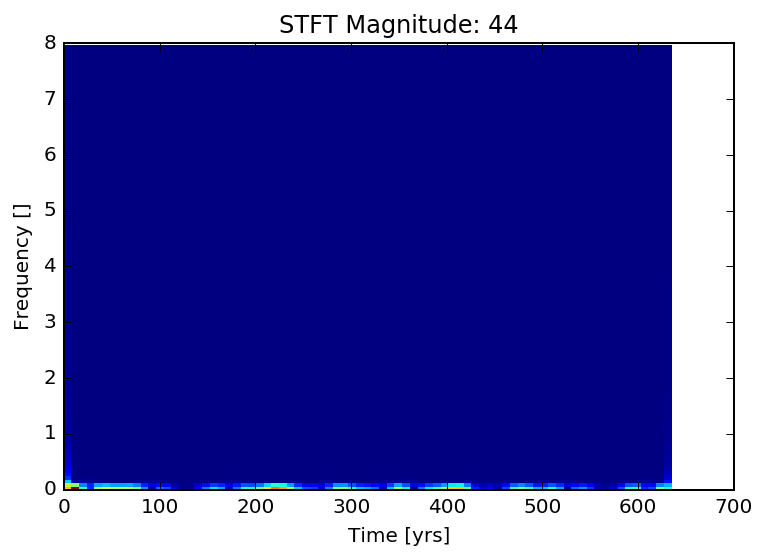

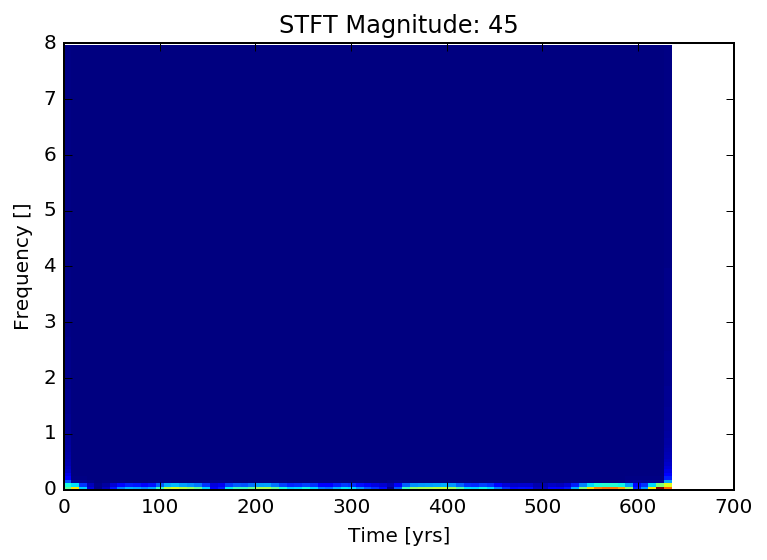

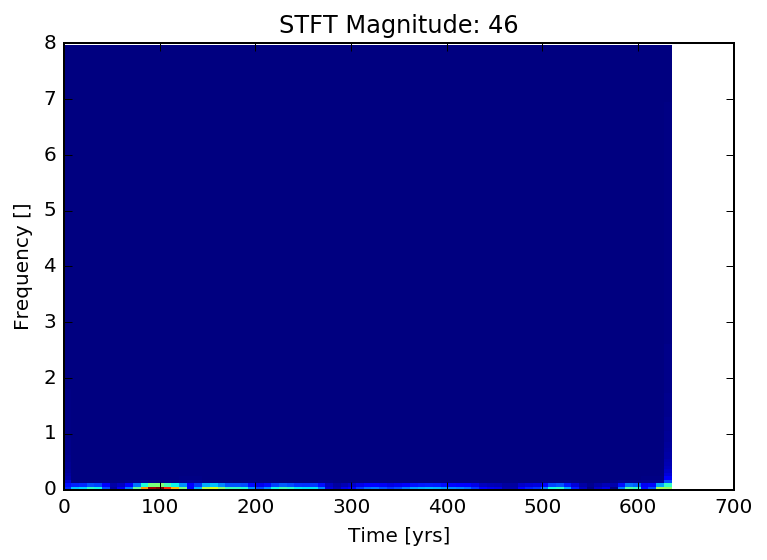

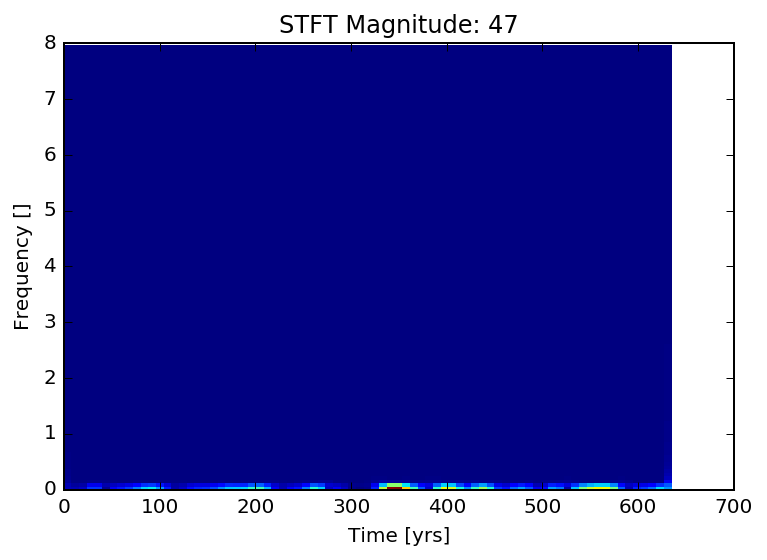

In [77]:
# N = 1e5
# time = np.arange(N)/50000.0
# mod = 10000*np.cos(2*np.pi*time)
# x = 10*np.sin(2*np.pi*5.0*time + mod)

palsampleslamstft = palsampleslampol.copy()
for i in range(48):
    x = palsampleslamstft[:,i]
    f, t, Zxx = signal.stft(x, fs=Nsamples/tsamples[-1])
    plt.pcolormesh(t, f, np.abs(Zxx))#, vmin=0, vmax=np.amax(np.abs(Zxx)/3) )
    plt.title('STFT Magnitude: ' + str(i))
    plt.ylabel('Frequency []')
    plt.xlabel('Time [yrs]')
    plt.show()

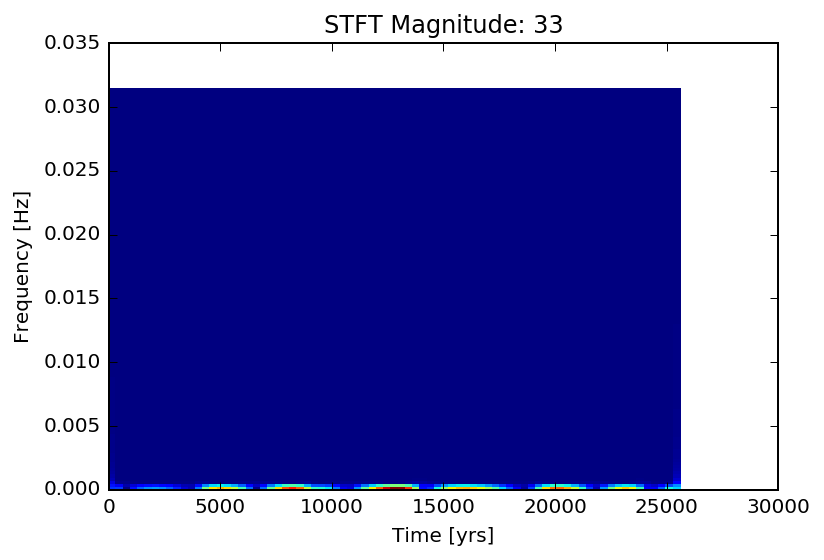

In [76]:
palsampleslamsft = palsampleslampol.copy()
x = palsampleslamsft[:,33]
f, t, Zxx = signal.stft(x, fs=(Nsamples/tsamples[-1])**(-1))
plt.pcolormesh(t/(2.0*np.pi), f, np.abs(Zxx))#, vmin=0, vmax=np.amax(np.abs(Zxx/3)) )
plt.title('STFT Magnitude: ' + str(33))
plt.ylabel('Frequency [Hz]')
# plt.ylim([0, 0.25])
plt.xlabel('Time [yrs]')
plt.show()

In [89]:
def plot_spectrogram(t, freqs, Zxx):
    fig, axs = plt.subplots(N-1,6, figsize=(15,7),sharex=True)
    for i in range(N-1):
        for j in range(6):
            ax = axs[i,j]# = plt.subplot(N-1,6,1+i*6+j)
            ax.set_yticks([])
            ax.set_xticks([])
            mi, ma = np.min(freqs[i*6+j]), np.max(freqs[i*6+j]/10)
            ax.set_ylim([mi-(ma-mi)*0.1, ma+(ma-mi)*0.1])
            ax.set_xlim([np.amin(t[i*6+j]), np.amax(t[i*6+j])])
            ax.pcolormesh(t[i*6+j], freqs[i*6+j], np.abs(Zxx[i*6+j]))#, vmin=0, vmax=np.amax(np.abs(Zxx/3)) )
            prob = dict(facecolor='white', alpha=0.75, edgecolor='white')
            ax.text(0.05,0.7,"%.1e"%(ma-mi),transform = ax.transAxes,color="black",bbox=prob)
    fig.text(0.5, 0.1, 'Time', ha='center')
    fig.text(0.1, 0.5, 'Frequency', va='center', rotation='vertical')
    fig.subplots_adjust(hspace=0.,wspace=0.)

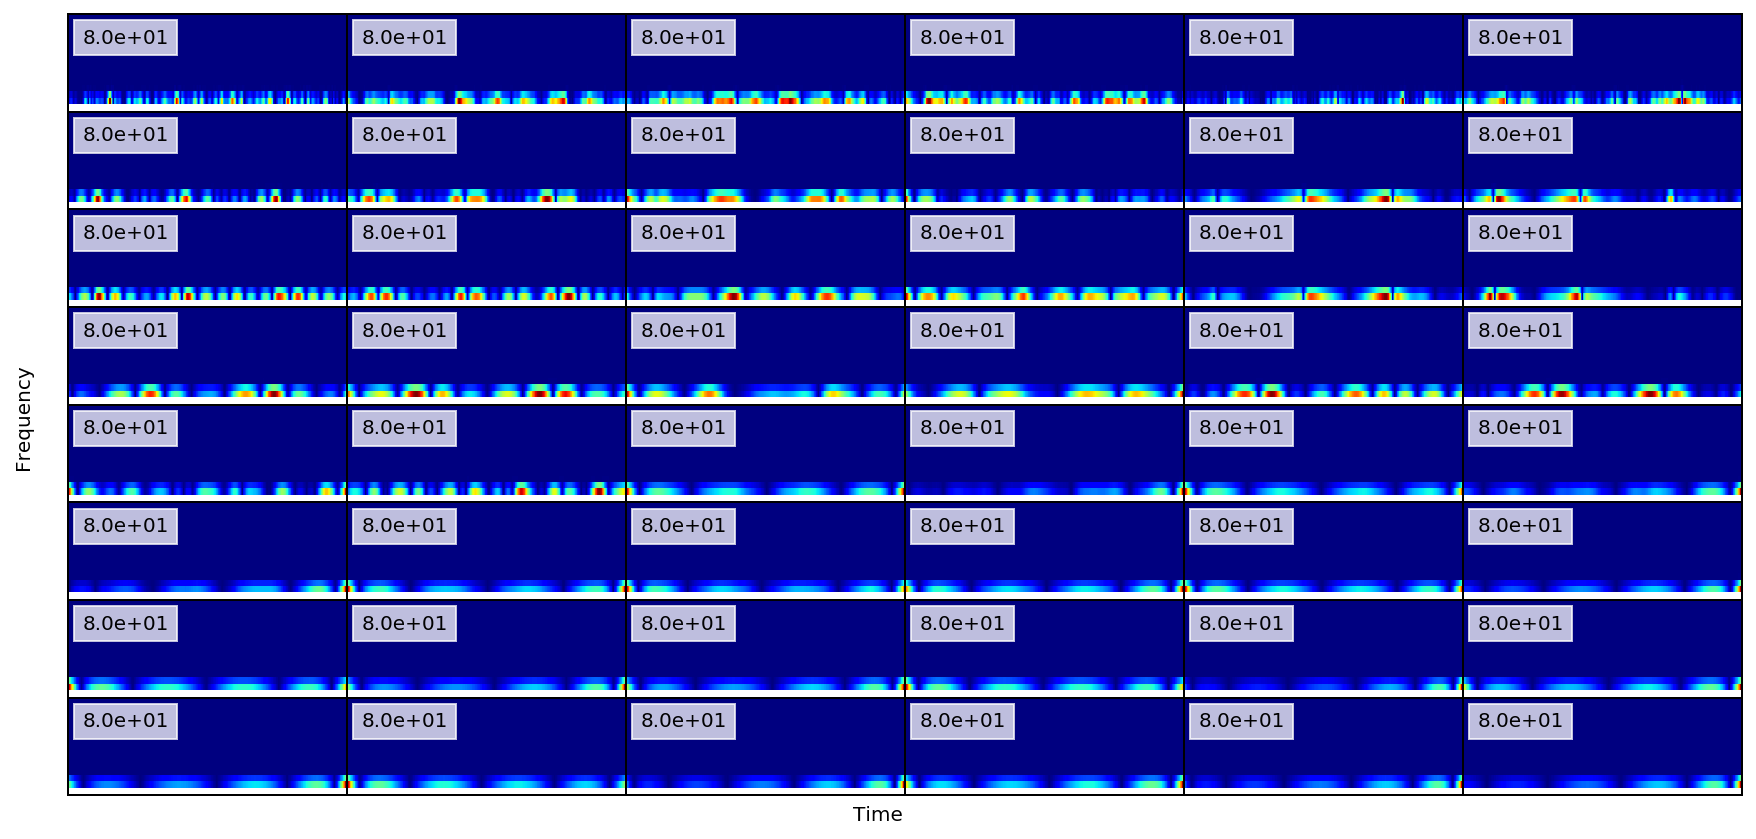

In [90]:
plot_spectrogram(T, F, np.abs(ZXX))

N:50000, T:5


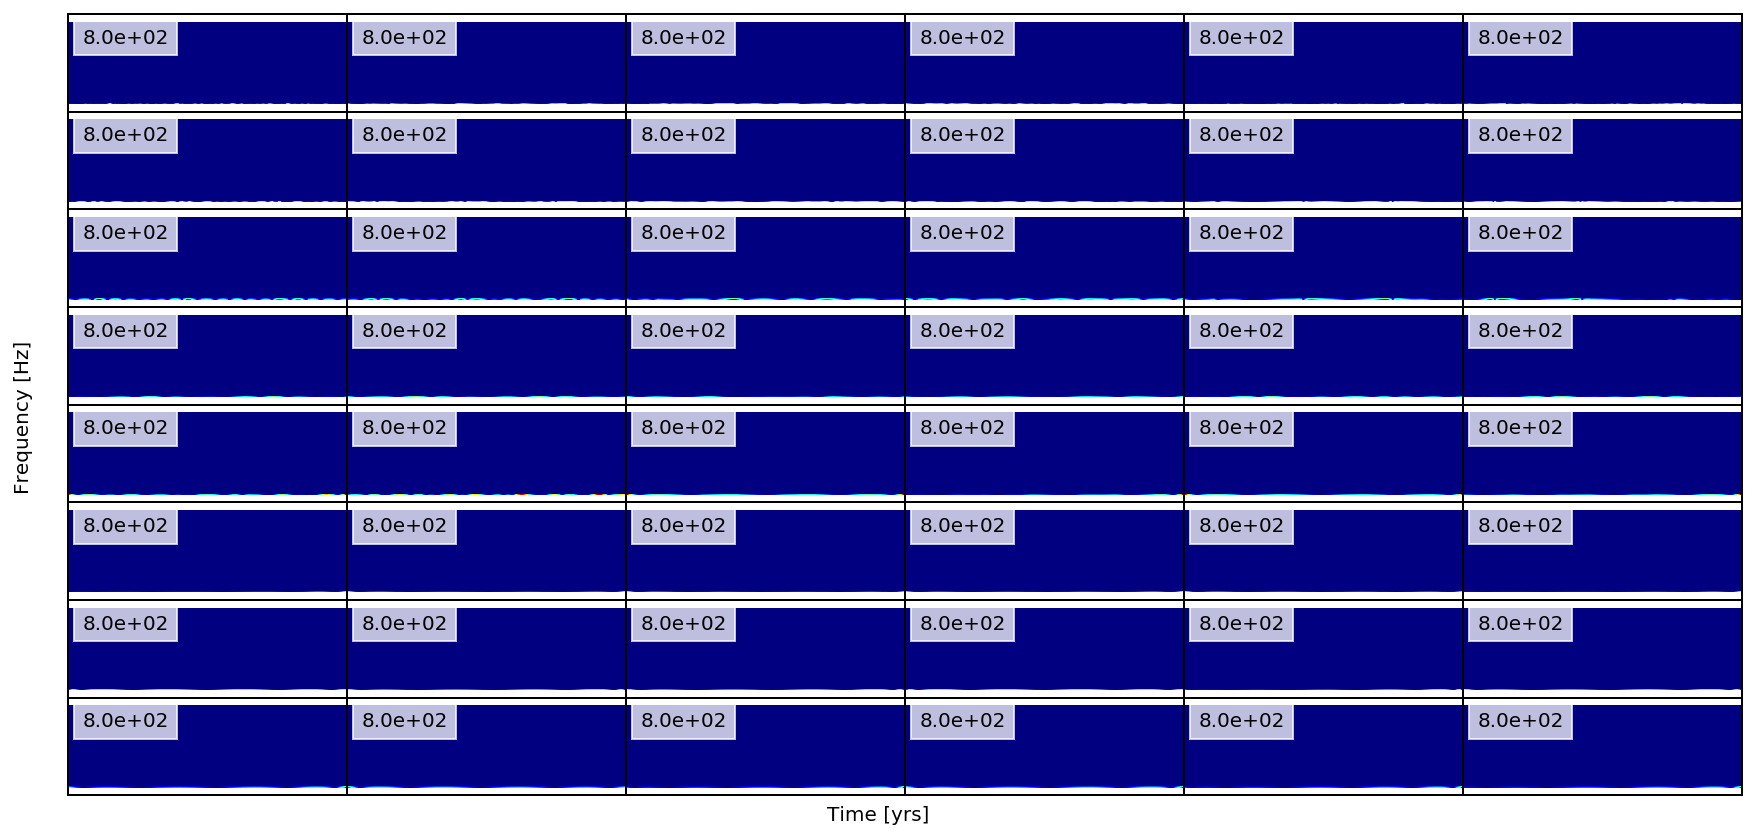

In [86]:
tmaxlist = [5.0, 10.0, 50.0, 100.0, 500.0]
nsampleslist = [1000, 5000, 10000, 50000]
# for TX in tmaxlist:
#     for NL in nsampleslist:
tmax = tmaxlist[0]*2.*np.pi
Nsamples = nsampleslist[3]
tsamples = tmax*np.linspace(0,1, Nsamples, endpoint=False)
sim = rebound.Simulation.from_file("ss.bin")
palsamples = np.zeros((Nsamples,6*(N-1)))
cartsamples = np.zeros((Nsamples,6*(N)))
for i in range(Nsamples):
    sim.integrate(tsamples[i])
    palsamples[i] = sim_to_pal(sim)
    cartsamples[i] = sim_to_car(sim)

palsampleslam = palsamples.copy()
sim = rebound.Simulation.from_file("ss.bin")
ns = np.zeros(N-1)
lam0 = np.zeros(N-1)
for j in range(1,N):
    ns[j-1] = sim.particles[j].n
    lam0[j-1] = palsamples[0,6*(j-1)+1]-ns[j-1]*tsamples[i]
for i in range(Nsamples):
    for j in range(1,N):
        palsampleslam[i,6*(j-1)+1] = mod2pi((palsamples[i,6*(j-1)+1]-lam0[j-1])-mod2pi(ns[j-1]*tsamples[i])+3.*np.pi)

palsampleslampol = palsampleslam.copy()
for i in range((N-1)*6):
    pol = np.polyfit(tsamples,palsampleslam[:,i],4)
    palsampleslampol[:,i] -= np.polyval(pol,tsamples)

palsampleslamstft = palsampleslampol.copy() #palsampleslam.copy()
x = palsampleslamstft[:,0]
f, t, Zxx = signal.stft(x, fs=Nsamples/tsamples[-1])
T = np.zeros((N*6, len(t)))
F = np.zeros((N*6, len(f)))
ZXX = np.zeros((N*6, len(Zxx), len(Zxx[0])), dtype=complex)
T[0] = t
F[0] = f
ZXX[0] = Zxx
for i in range(1,48):
    x = palsampleslamstft[:,i]
    F[i], T[i], ZXX[i] = signal.stft(x, fs=Nsamples/tsamples[-1])
print('N:'+str(Nsamples)+', T:'+str(int(tmax/(2*np.pi))))
plot_spectrogram(T, F, np.abs(ZXX))

### Scratch

In [25]:
# palpca = palsamples.copy()
# pca = PCA()
# palpcatrans = pca.fit_transform(palpca)
# mu = np.mean(palpca, axis=0)
# nComp = 24
# Xhat = np.dot(palpcatrans[:,:nComp], pca.components_[:nComp,:])
# Xhat += mu

# plot_pal(tsamples, Xhat, palpca)
# met = np.zeros(Nsamples)
# for i in range(Nsamples):
#     met[i] = metric(pal_to_sim(palpca[i]), pal_to_sim(Xhat[i]))
# print '{0:1.11e}'.format(np.mean(met))

# plt.plot(tsamples, palpcatrans[:,:])
# plt.show()

# plot_pal(tsamples, palpcatrans)
# plt.plot(tsamples, met)
# plt.yscale('log')
# plt.show()

In [26]:
# palpca = palsampleslam.copy()
# pca = PCA()
# palpcatrans = pca.fit_transform(palpca)
# mu = np.mean(palpca, axis=0)
# nComp = 24
# Xhat = np.dot(palpcatrans[:,:nComp], pca.components_[:nComp,:])
# Xhat += mu
# plot_pal(tsamples, Xhat, palpca)

# met = np.zeros(Nsamples)
# for i in range(Nsamples):
#     met[i] = metric(pal_to_sim(palpca[i]), pal_to_sim(Xhat[i]))
# print(np.mean(met))

# plt.plot(tsamples, palpcatrans[:,:])
# plt.show()

# plot_pal(tsamples, palpcatrans)

# plt.plot(tsamples, met)
# plt.yscale('log')
# plt.show()

In [27]:
# palpca = palsampleslampol.copy()
# pca = PCA()
# palpcatrans = pca.fit_transform(palpca)
# mu = np.mean(palpca, axis=0)
# nComp = 24
# # print (pca.transform(palpca)[:,:nComp]).shape
# Xhat = np.dot(palpcatrans[:,:nComp], pca.components_[:nComp,:])
# Xhat += mu

# diff = np.absolute(palpca - Xhat)
# print np.mean(np.mean(diff, axis=1))

# plt.plot(tsamples, palpcatrans[:,:])
# plt.show()

# plot_pal(tsamples, palpcatrans)

# for i in range((N-1)*6):
#     pol = np.polyfit(tsamples,palsampleslam[:,i],4)
#     Xhat[:,i] += np.polyval(pol,tsamples)
    
# # plot_pal(tsamples, palpca - Xhat)
# met = np.zeros(Nsamples)
# for i in range(Nsamples):
#     met[i] = metric(pal_to_sim(palsampleslam[i]), pal_to_sim(Xhat[i]))
# print '{0:1.11e}'.format(np.mean(met))
# plt.plot(tsamples, met)
# plt.yscale('log')
# plt.show()

In [28]:
# results = PCA(palsamples)
# resultslam = PCA(palsampleslam)
# resultslampol = PCA(palsampleslampol)
# fracN = np.arange(len(results.fracs))

In [29]:
# plt.plot(fracN, results.fracs, fracN, resultslam.fracs, fracN, resultslampol.fracs)
# plt.yscale('log')
# plt.show()

In [30]:
# plt.scatter(results.Y[0], results.Y[1])
# plt.show()

In [31]:
# plot_pal(tsamples, (results.Y)*(results.fracs) + (results.mu))

In [32]:
# Useful things to use in iPython
# Use Python 3
# plt.scatter?
# %debug